## Unsupervised cross-domain translation via deep learning and adversarial attention neural networks and application to music-inspired protein designs
#### Markus J. Buehler, MIT, 2022-2023
#### mbuehler@MIT.EDU
###### Published in: Patterns, 2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import tqdm
from scipy import stats
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import itertools
from torch.autograd import Variable
import statistics
from midiutil.MidiFile import MIDIFile  # pip install midiutil 
from math import pi, log
from functools import wraps
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat 
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import random

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [4]:
print("Torch version:", torch.__version__) 

Torch version: 1.12.0+cu113


In [5]:
#Code snippets from:
#https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/cyclegan  
#https://github.com/lucidrains/perceiver-pytorch/blob/main/perceiver_pytorch/perceiver_io.py
#https://github.com/aitorzip/PyTorch-CycleGAN
#https://github.com/lucidrains/x-transformers 

### Additional parameters

In [6]:
BATCH_SIZE=4

In [7]:
music_shift=False  #if set True then shift music data by smallest token so that it starts at 1
option = 0 #synthetic dataset (generated)
option = 10 #music-protein dataset (load from numpy)

In [8]:
# Load dataset
if option == 0: 
    seq_length=128
    min_notes = 128 #minimum number of notes we want per sequence snippet
    num_data_points=5000
   
    minrepeat=6 #min clister size
    maxrepeat=24 #max cluster size
    num_draws=int (seq_length/minrepeat)
   
    for ll in range (num_data_points):
        
        value = np.random.randint(minrepeat, maxrepeat, size=num_draws) 
      
        tmpp=[]
        tmpp2=[]
        for i in range (len (value)):

            tmpp.extend( [(i%2)*1+1]*value[i] )
            tmpp2.extend( [10-(i%2)*1+1]*value[i] )
            
            tmpp = tmpp [:seq_length]
            tmpp2 = tmpp2 [:seq_length]

        tmpp=np.array(tmpp)
        tmpp=np.expand_dims(tmpp, 0)
        tmpp2=np.array(tmpp2)
        tmpp2=np.expand_dims(tmpp2, 0)
        
        
        if ll==0:

            music_data = tmpp
            protein_data = tmpp2

        else: 
            music_data=np.append ( music_data, tmpp , axis=0 )
            protein_data=np.append ( protein_data, tmpp2 , axis=0 )

if option == 10: #load numpy
    
    music_shift=True
    filenXb='Goldberg_extended_256.npy'
    music_data=np.load(filenXb, allow_pickle=True, fix_imports=True )
    
    filenXb='Protein_extended_256.npy'
    protein_data=np.load(filenXb, allow_pickle=True, fix_imports=True )
    print (protein_data.shape)
    
print (music_data.shape)
print (protein_data.shape)

(14385, 256)
(17659, 256)
(14385, 256)


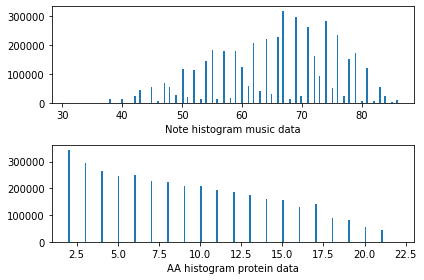

In [9]:
fig, axs = plt.subplots(2, 1,  tight_layout=True) #sharey=True,

axs[0].hist (music_data.flatten(), bins=200)
axs[0].set_xlabel ('Note histogram music data')

axs[1].hist (protein_data.flatten(), bins=200)
#axs[1].set_ylabel ('Music sequence length')
axs[1].set_xlabel ('AA histogram protein data')

plt.show()

In [10]:
if music_shift:

    music_shift_token=min(music_data.flatten() -1 )

    music_data=music_data-      music_shift_token    

    print ("Music data shifted by=", music_shift_token)
else:
    music_shift_token=0
    
    print ("Music data NOT shifted... music_shift_token=", music_shift_token)

Music data shifted by= 30.0


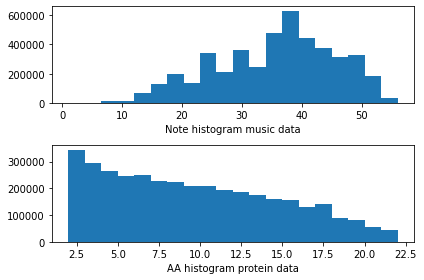

In [11]:
fig, axs = plt.subplots(2, 1,  tight_layout=True) #sharey=True,

axs[0].hist (music_data.flatten(), bins=20)
axs[0].set_xlabel ('Note histogram music data')

axs[1].hist (protein_data.flatten(), bins=20)
#axs[1].set_ylabel ('Music sequence length')
axs[1].set_xlabel ('AA histogram protein data')

plt.show()

In [12]:
seq_length=music_data.shape[1]

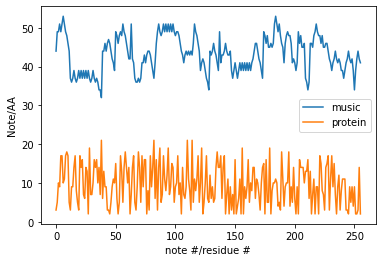

In [13]:
data1='music'
data2='protein'
elements='note #/residue #'
Note='Note'
AA='AA'
Note_AA='Note/AA'

plt.plot ( music_data[0,:], label =f'{data1}')
plt.plot ( protein_data[0,:], label =f'{data2}')
plt.legend ()
plt.xlabel (f'{elements}')
plt.ylabel (f'{Note_AA}')
plt.show ()

### Now set up neural nets

In [14]:
#https://github.com/lucidrains/perceiver-pytorch 
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, _cache = True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim = None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)

        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context = normed_context)

        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, query_dim, context_dim = None, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)
        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Linear(inner_dim, query_dim)

    def forward(self, x, context = None, mask = None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h = h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention, what we cannot get enough of
        attn = sim.softmax(dim = -1)
        attn = self.dropout(attn)
        
        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)
        return self.to_out(out)

class Conv1DModule(nn.Module):
    def __init__(self, latent_dim, kernel_size):
        super().__init__()
        self.Conv1=nn.Conv1d(in_channels=latent_dim ,out_channels= latent_dim, \
                                            kernel_size=  kernel_size , stride=1, \
                                        padding='same')

    def forward(self, x, **kwargs):
        x=torch.permute(x, (0,2,1)  )
        x = self.Conv1 (x)
        x=torch.permute(x, (0,2,1)  )

        return x#self.fn(x, **kwargs)

class PerceiverIO(nn.Module):
    def __init__(
        self,
        *,
        depth,
        dim,
        queries_dim,
        logits_dim = None,
        num_latents = 512,
        latent_dim = 512,
        cross_heads = 1,
        latent_heads = 8,
        cross_dim_head = 64,
        latent_dim_head = 64,
        weight_tie_layers = False,
        decoder_ff = False,
        attn_dropout = 0.,
        ff_dropout = 0.,
        perceiver_conv=False,
         kernel_size=3, 
        
    ):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))

        self.cross_attend_blocks = nn.ModuleList([
            PreNorm(latent_dim, Attention(latent_dim, dim, heads = cross_heads, dim_head = cross_dim_head, \
                                          dropout = attn_dropout), context_dim = dim),
            PreNorm(latent_dim, FeedForward(latent_dim,dropout = ff_dropout))
        ])

        self.perceiver_conv=perceiver_conv
        get_latent_attn = lambda: PreNorm(latent_dim, Attention(latent_dim, heads = latent_heads, \
                                                                dim_head = latent_dim_head, dropout = attn_dropout))
        get_latent_ff = lambda: PreNorm(latent_dim, FeedForward(latent_dim,dropout = ff_dropout))
        
        get_conv_layer = lambda: Conv1DModule (latent_dim, kernel_size)
        
        get_latent_attn, get_latent_ff,get_conv_layer  = map(cache_fn, (get_latent_attn, get_latent_ff, get_conv_layer ))
        
        self.layers = nn.ModuleList([])
        cache_args = {'_cache': weight_tie_layers}

        for i in range(depth):
            self.layers.append(nn.ModuleList([
                get_latent_attn(**cache_args),
                get_latent_ff(**cache_args),
                get_conv_layer (**cache_args)
            ]))

        self.decoder_cross_attn = PreNorm(queries_dim, Attention(queries_dim, latent_dim, heads = cross_heads, \
                                                                 dim_head = cross_dim_head, dropout = attn_dropout), context_dim = latent_dim)
        self.decoder_ff = PreNorm(queries_dim, FeedForward(queries_dim)) if decoder_ff else None

        self.to_logits = nn.Linear(queries_dim, logits_dim) if exists(logits_dim) else nn.Identity()

    def forward(
        self,
        data,
        mask = None,
        queries = None
    ):
        b, *_, device = *data.shape, data.device

        x = repeat(self.latents, 'n d -> b n d', b = b)

        cross_attn, cross_ff = self.cross_attend_blocks

        x = cross_attn(x, context = data, mask = mask) + x
        x = cross_ff(x) + x

        for conv, self_attn, self_ff in self.layers:
            x = self_attn(x) + x
            x = self_ff(x) + x
            if self.perceiver_conv:
                #print (x.shape)
                #x=torch.permute(x, (0,2,1)  )
                #print (x.shape)
                x = conv (x) + x
               # x=torch.permute(x, (0,2,1)  )
        if not exists(queries):
            return x
        
        if queries.ndim == 2:
            queries = repeat(queries, 'n d -> b n d', b = b)
        
        latents = self.decoder_cross_attn(queries, context = x)

        if exists(self.decoder_ff):
            latents = latents + self.decoder_ff(latents)

        return self.to_logits(latents)

In [15]:
#from: https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py - Version: 0.27.0
import math
import torch
from torch import nn, einsum
import torch.nn.functional as F
from functools import partial
from inspect import isfunction
from collections import namedtuple

from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange

from entmax import entmax15

DEFAULT_DIM_HEAD = 64

Intermediates = namedtuple('Intermediates', [
    'pre_softmax_attn',
    'post_softmax_attn'
])

LayerIntermediates = namedtuple('Intermediates', [
    'hiddens',
    'attn_intermediates'
])

def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth

class always():
    def __init__(self, val):
        self.val = val
    def __call__(self, *args, **kwargs):
        return self.val

class not_equals():
    def __init__(self, val):
        self.val = val
    def __call__(self, x, *args, **kwargs):
        return x != self.val

class equals():
    def __init__(self, val):
        self.val = val
    def __call__(self, x, *args, **kwargs):
        return x == self.val

def max_neg_value(tensor):
    return -torch.finfo(tensor.dtype).max

def l2norm(t):
    return F.normalize(t, p = 2, dim = -1)

def stable_softmax(t, dim = -1):
    t = t - t.amax(dim = dim, keepdim = True).detach()
    return F.softmax(t, dim = dim)

# init helpers

def init_zero_(layer):
    nn.init.constant_(layer.weight, 0.)
    if exists(layer.bias):
        nn.init.constant_(layer.bias, 0.)

# keyword argument helpers

def pick_and_pop(keys, d):
    values = list(map(lambda key: d.pop(key), keys))
    return dict(zip(keys, values))

def group_dict_by_key(cond, d):
    return_val = [dict(),dict()]
    for key in d.keys():
        match = bool(cond(key))
        ind = int(not match)
        return_val[ind][key] = d[key]
    return (*return_val,)

def string_begins_with(prefix, str):
    return str.startswith(prefix)

def group_by_key_prefix(prefix, d):
    return group_dict_by_key(partial(string_begins_with, prefix), d)

def groupby_prefix_and_trim(prefix, d):
    kwargs_with_prefix, kwargs = group_dict_by_key(partial(string_begins_with, prefix), d)
    kwargs_without_prefix = dict(map(lambda x: (x[0][len(prefix):], x[1]), tuple(kwargs_with_prefix.items())))
    return kwargs_without_prefix, kwargs

# activations

class ReluSquared(nn.Module):
    def forward(self, x):
        return F.relu(x) ** 2

# embedding

class TokenEmbedding(nn.Module):
    def __init__(self, dim, num_tokens, l2norm_embed = False):
        super().__init__()
        self.l2norm_embed = l2norm_embed
        self.emb = nn.Embedding(num_tokens, dim)

    def forward(self, x):
        token_emb = self.emb(x)
        return l2norm(token_emb) if self.l2norm_embed else token_emb

# positional embeddings

class AbsolutePositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len, l2norm_embed = False):
        super().__init__()
        self.scale = dim ** -0.5 if not l2norm_embed else 1.
        self.l2norm_embed = l2norm_embed
        self.emb = nn.Embedding(max_seq_len, dim)

    def forward(self, x, pos = None):
        if not exists(pos):
            pos = torch.arange(x.shape[1], device = x.device)

        pos_emb = self.emb(pos)
        pos_emb = pos_emb * self.scale
        return l2norm(pos_emb) if self.l2norm_embed else pos_emb

class FixedPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x, pos = None, seq_dim = 1, offset = 0):
        if not exists(pos):
            pos = torch.arange(x.shape[seq_dim], device = x.device)

        pos = pos.type_as(self.inv_freq) + offset
        sinusoid_inp = pos.unsqueeze(-1) * self.inv_freq
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        return emb

class RelativePositionBias(nn.Module):
    def __init__(self, scale, causal = False, num_buckets = 32, max_distance = 128, heads = 8):
        super().__init__()
        self.scale = scale
        self.causal = causal
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.relative_attention_bias = nn.Embedding(num_buckets, heads)

    @staticmethod
    def _relative_position_bucket(relative_position, causal = True, num_buckets = 32, max_distance = 128):
        ret = 0
        n = -relative_position
        if not causal:
            num_buckets //= 2
            ret += (n < 0).long() * num_buckets
            n = torch.abs(n)
        else:
            n = torch.max(n, torch.zeros_like(n))

        max_exact = num_buckets // 2
        is_small = n < max_exact

        val_if_large = max_exact + (
            torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact)
        ).long()
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))

        ret += torch.where(is_small, n, val_if_large)
        return ret

    def forward(self, qk_dots):
        i, j, device = *qk_dots.shape[-2:], qk_dots.device
        q_pos = torch.arange(i, dtype = torch.long, device = device)
        k_pos = torch.arange(j, dtype = torch.long, device = device)
        rel_pos = k_pos[None, :] - q_pos[:, None]
        rp_bucket = self._relative_position_bucket(rel_pos, causal = self.causal, num_buckets = self.num_buckets, max_distance = self.max_distance)
        values = self.relative_attention_bias(rp_bucket)
        bias = rearrange(values, 'i j h -> h i j')
        return qk_dots + (bias * self.scale)

class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, qk_dots):
        n, device, dtype = qk_dots.shape[-1], qk_dots.device, qk_dots.dtype

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)

        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')

        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return qk_dots + bias

class AlibiPositionalBias(nn.Module):
    def __init__(self, heads, **kwargs):
        super().__init__()
        self.heads = heads
        slopes = torch.Tensor(self._get_slopes(heads))
        slopes = rearrange(slopes, 'h -> h 1 1')
        self.register_buffer('slopes', slopes, persistent = False)
        self.register_buffer('bias', None, persistent = False)

    @staticmethod
    def _get_slopes(heads):
        def get_slopes_power_of_2(n):
            start = (2**(-2**-(math.log2(n)-3)))
            ratio = start
            return [start*ratio**i for i in range(n)]

        if math.log2(heads).is_integer():
            return get_slopes_power_of_2(heads)

        closest_power_of_2 = 2 ** math.floor(math.log2(heads))
        return get_slopes_power_of_2(closest_power_of_2) + get_slopes_power_of_2(2 * closest_power_of_2)[0::2][:heads-closest_power_of_2]

    def forward(self, qk_dots):
        h, i, j, device = *qk_dots.shape[-3:], qk_dots.device

        if exists(self.bias) and self.bias.shape[-1] >= j:
            return qk_dots + self.bias[..., :j]

        bias = torch.arange(j, device = device)
        bias = bias * self.slopes

        num_heads_unalibied = h - bias.shape[1]
        bias = F.pad(bias, (0, 0, 0, 0, 0, num_heads_unalibied))

        self.register_buffer('bias', bias, persistent = False)
        return qk_dots + self.bias

class LearnedAlibiPositionalBias(AlibiPositionalBias):
    def __init__(self, heads, bidirectional = False):
        super().__init__(heads)
        log_slopes = torch.log(self.slopes)
        self.learned_logslopes = nn.Parameter(log_slopes)

        self.bidirectional = bidirectional
        if self.bidirectional:
            self.learned_logslopes_future = nn.Parameter(log_slopes)

    def forward(self, qk_dots):
        h, i, j, device = *qk_dots.shape[-3:], qk_dots.device

        def get_slopes(param):
            return F.pad(param.exp(), (0, 0, 0, 0, 0, h - param.shape[1]))

        if exists(self.bias) and self.bias.shape[-1] >= j:
            bias = self.bias[..., :i, :j]
        else:
            i_arange = torch.arange(i, device = device)
            j_arange = torch.arange(j, device = device)
            bias = rearrange(j_arange, 'j -> 1 1 1 j') - rearrange(i_arange, 'i -> 1 1 i 1')
            self.register_buffer('bias', bias, persistent = False)

        if self.bidirectional:
            past_slopes = get_slopes(self.learned_logslopes)
            future_slopes = get_slopes(self.learned_logslopes_future)
            bias = bias.abs()
            bias = torch.tril(bias * past_slopes) + torch.triu(bias * future_slopes)
        else:
            slopes = get_slopes(self.learned_logslopes)
            bias = bias * slopes

        return qk_dots + bias

class RotaryEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, max_seq_len, device):
        t = torch.arange(max_seq_len, device = device).type_as(self.inv_freq)
        freqs = torch.einsum('i , j -> i j', t, self.inv_freq)
        return torch.cat((freqs, freqs), dim=-1)

def rotate_half(x):
    x = rearrange(x, '... (j d) -> ... j d', j = 2)
    x1, x2 = x.unbind(dim = -2)
    return torch.cat((-x2, x1), dim = -1)

def apply_rotary_pos_emb(t, freqs):
    seq_len = t.shape[-2]
    freqs = freqs[-seq_len:, :]
    return (t * freqs.cos()) + (rotate_half(t) * freqs.sin())

# norms

class Scale(nn.Module):
    def __init__(self, value, fn):
        super().__init__()
        self.value = value
        self.fn = fn

    def forward(self, x, **kwargs):
        out = self.fn(x, **kwargs)
        scale_fn = lambda t: t * self.value

        if not isinstance(out, tuple):
            return scale_fn(out)

        return (scale_fn(out[0]), *out[1:])

class ScaleNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.scale = dim ** -0.5
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1))

    def forward(self, x):
        norm = torch.norm(x, dim = -1, keepdim = True) * self.scale
        return x / norm.clamp(min = self.eps) * self.g

class RMSNorm(nn.Module):
    def __init__(self, dim, eps = 1e-8):
        super().__init__()
        self.scale = dim ** -0.5
        self.eps = eps
        self.g = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        norm = torch.norm(x, dim = -1, keepdim = True) * self.scale
        return x / norm.clamp(min = self.eps) * self.g

# residual and residual gates

class Residual(nn.Module):
    def __init__(self, dim, scale_residual = False, scale_residual_constant = 1.):
        super().__init__()
        self.residual_scale = nn.Parameter(torch.ones(dim)) if scale_residual else None
        self.scale_residual_constant = scale_residual_constant

    def forward(self, x, residual):
        if exists(self.residual_scale):
            residual = residual * self.residual_scale

        if self.scale_residual_constant != 1:
            residual = residual * self.scale_residual_constant

        return x + residual

class GRUGating(nn.Module):
    def __init__(self, dim, scale_residual = False, **kwargs):
        super().__init__()
        self.gru = nn.GRUCell(dim, dim)
        self.residual_scale = nn.Parameter(torch.ones(dim)) if scale_residual else None

    def forward(self, x, residual):
        if exists(self.residual_scale):
            residual = residual * self.residual_scale

        gated_output = self.gru(
            rearrange(x, 'b n d -> (b n) d'),
            rearrange(residual, 'b n d -> (b n) d')
        )

        return gated_output.reshape_as(x)

# token shifting

def shift(t, amount, mask = None):
    if amount == 0:
        return t

    if exists(mask):
        t = t.masked_fill(~mask[..., None], 0.)

    return F.pad(t, (0, 0, amount, -amount), value = 0.)

class ShiftTokens(nn.Module):
    def __init__(self, shifts, fn):
        super().__init__()
        self.fn = fn
        self.shifts = tuple(shifts)

    def forward(self, x, **kwargs):
        mask = kwargs.get('mask', None)
        shifts = self.shifts
        segments = len(shifts)
        feats_per_shift = x.shape[-1] // segments
        splitted = x.split(feats_per_shift, dim = -1)
        segments_to_shift, rest = splitted[:segments], splitted[segments:]
        segments_to_shift = list(map(lambda args: shift(*args, mask = mask), zip(segments_to_shift, shifts)))
        x = torch.cat((*segments_to_shift, *rest), dim = -1)
        return self.fn(x, **kwargs)

# feedforward

class GLU(nn.Module):
    def __init__(self, dim_in, dim_out, activation):
        super().__init__()
        self.act = activation
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim = -1)
        return x * self.act(gate)

class Transformer_FeedForward(nn.Module):
    def __init__(
        self,
        dim,
        dim_out = None,
        mult = 4,
        glu = False,
        swish = False,
        relu_squared = False,
        post_act_ln = False,
        dropout = 0.,
        no_bias = False,
        zero_init_output = False
    ):
        super().__init__()
        inner_dim = int(dim * mult)
        dim_out = default(dim_out, dim)

        if relu_squared:
            activation = ReluSquared()
        elif swish:
            activation = nn.SiLU()
        else:
            activation = nn.GELU()

        project_in = nn.Sequential(
            nn.Linear(dim, inner_dim, bias = not no_bias),
            activation
        ) if not glu else GLU(dim, inner_dim, activation)

        self.net = nn.Sequential(
            project_in,
            nn.LayerNorm(inner_dim) if post_act_ln else nn.Identity(),
            nn.Dropout(dropout),
            nn.Linear(inner_dim, dim_out, bias = not no_bias)
        )

        # init last linear layer to 0
        if zero_init_output:
            init_zero_(self.net[-1])

    def forward(self, x):
        return self.net(x)

# attention.

class Transformer_Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = DEFAULT_DIM_HEAD,
        heads = 8,
        causal = False,
        talking_heads = False,
        head_scale = False,
        sparse_topk = None,
        use_entmax15 = False,
        num_mem_kv = 0,
        dropout = 0.,
        on_attn = False,
        gate_values = False,
        zero_init_output = False,
        max_attend_past = None,
        qk_norm = False,
        scale_init_value = None,
        one_kv_head = False,
        value_dim_head = None,
    ):
        super().__init__()
        self.scale = dim_head ** -0.5

        self.heads = heads
        self.causal = causal
        self.max_attend_past = max_attend_past

        value_dim_head = default(value_dim_head, dim_head)
        q_dim = k_dim = dim_head * heads
        v_dim = out_dim = value_dim_head * heads

        self.one_kv_head = one_kv_head
        if one_kv_head:
            k_dim = dim_head
            v_dim = value_dim_head
            out_dim = v_dim * heads

        self.to_q = nn.Linear(dim, q_dim, bias = False)
        self.to_k = nn.Linear(dim, k_dim, bias = False)
        self.to_v = nn.Linear(dim, v_dim, bias = False)

        self.dropout = nn.Dropout(dropout)

        # add GLU gating for aggregated values, from alphafold2
        self.to_v_gate = None
        if gate_values:
            self.to_v_gate = nn.Linear(dim, out_dim)
            nn.init.constant_(self.to_v_gate.weight, 0)
            nn.init.constant_(self.to_v_gate.bias, 1)

        # cosine sim attention
        self.qk_norm = qk_norm
        if qk_norm:
            scale_init_value = default(scale_init_value, -3) # if not provided, initialize as though it were sequence length of 1024
            self.scale = nn.Parameter(torch.ones(1, heads, 1, 1) * scale_init_value)

        # talking heads
        self.talking_heads = talking_heads
        if talking_heads:
            self.pre_softmax_talking_heads = nn.Conv2d(heads, heads, 1, bias = False)
            self.post_softmax_talking_heads = nn.Conv2d(heads, heads, 1, bias = False)

        # head scaling
        self.head_scale = head_scale
        if head_scale:
            self.head_scale_params = nn.Parameter(torch.ones(1, heads, 1, 1))

        # explicit topk sparse attention
        self.sparse_topk = sparse_topk

        # entmax
        self.attn_fn = entmax15 if use_entmax15 else stable_softmax

        # add memory key / values
        self.num_mem_kv = num_mem_kv
        if num_mem_kv > 0:
            self.mem_k = nn.Parameter(torch.randn(heads, num_mem_kv, dim_head))
            self.mem_v = nn.Parameter(torch.randn(heads, num_mem_kv, dim_head))

        # attention on attention
        self.attn_on_attn = on_attn
        self.to_out = nn.Sequential(nn.Linear(out_dim, dim * 2, bias = False), nn.GLU()) if on_attn else nn.Linear(out_dim, dim, bias = False)

        # init output projection 0
        if zero_init_output:
            init_zero_(self.to_out)

    def forward(
        self,
        x,
        context = None,
        mask = None,
        context_mask = None,
        attn_mask = None,
        rel_pos = None,
        sinusoidal_emb = None,
        rotary_pos_emb = None,
        prev_attn = None,
        mem = None
    ):
        b, n, _, h, talking_heads, head_scale, scale, device, has_context = *x.shape, self.heads, self.talking_heads, self.head_scale, self.scale, x.device, exists(context)
        kv_input = default(context, x)

        q_input = x
        k_input = kv_input
        v_input = kv_input

        if exists(mem):
            k_input = torch.cat((mem, k_input), dim = -2)
            v_input = torch.cat((mem, v_input), dim = -2)

        if exists(sinusoidal_emb):
            # in shortformer, the query would start at a position offset depending on the past cached memory
            offset = k_input.shape[-2] - q_input.shape[-2]
            q_input = q_input + sinusoidal_emb(q_input, offset = offset)
            k_input = k_input + sinusoidal_emb(k_input)

        q = self.to_q(q_input)
        k = self.to_k(k_input)
        v = self.to_v(v_input)

        q = rearrange(q, 'b n (h d) -> b h n d', h = h)

        if not self.one_kv_head:
            k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (k, v))

        if exists(rotary_pos_emb) and not has_context:
            l = rotary_pos_emb.shape[-1]
            (ql, qr), (kl, kr), (vl, vr) = map(lambda t: (t[..., :l], t[..., l:]), (q, k, v))
            ql, kl, vl = map(lambda t: apply_rotary_pos_emb(t, rotary_pos_emb), (ql, kl, vl))
            q, k, v = map(lambda t: torch.cat(t, dim = -1), ((ql, qr), (kl, kr), (vl, vr)))

        input_mask = None
        if any(map(exists, (mask, context_mask))):
            q_mask = default(mask, lambda: torch.ones((b, n), device = device).bool())
            k_mask = q_mask if not exists(context) else context_mask
            k_mask = default(k_mask, lambda: torch.ones((b, k.shape[-2]), device = device).bool())
            q_mask = rearrange(q_mask, 'b i -> b 1 i 1')
            k_mask = rearrange(k_mask, 'b j -> b 1 1 j')
            input_mask = q_mask * k_mask

        if self.num_mem_kv > 0:
            mem_k, mem_v = map(lambda t: repeat(t, 'h n d -> b h n d', b = b), (self.mem_k, self.mem_v))
            k = torch.cat((mem_k, k), dim = -2)
            v = torch.cat((mem_v, v), dim = -2)
            if exists(input_mask):
                input_mask = F.pad(input_mask, (self.num_mem_kv, 0), value = True)

        if self.qk_norm:
            q, k = map(l2norm, (q, k))
            scale = 1 / (self.scale.exp().clamp(min = 1e-2))

        kv_einsum_eq = 'b h j d' if not self.one_kv_head else 'b j d'

        dots = einsum(f'b h i d, {kv_einsum_eq} -> b h i j', q, k) * scale
        mask_value = max_neg_value(dots)

        if exists(prev_attn):
            dots = dots + prev_attn

        pre_softmax_attn = dots.clone()

        if talking_heads:
            dots = self.pre_softmax_talking_heads(dots)

        if exists(rel_pos):
            dots = rel_pos(dots)

        if exists(input_mask):
            dots.masked_fill_(~input_mask, mask_value)
            del input_mask

        if exists(attn_mask):
            assert 2 <= attn_mask.ndim <= 4, 'attention mask must have greater than 2 dimensions but less than or equal to 4'
            if attn_mask.ndim == 2:
                attn_mask = rearrange(attn_mask, 'i j -> 1 1 i j')
            elif attn_mask.ndim == 3:
                attn_mask = rearrange(attn_mask, 'h i j -> 1 h i j')
            dots.masked_fill_(~attn_mask, mask_value)

        if exists(self.max_attend_past):
            i, j = dots.shape[-2:]
            range_q = torch.arange(j - i, j, device = device)
            range_k = torch.arange(j, device = device)
            dist = rearrange(range_q, 'i -> 1 1 i 1') - rearrange(range_k, 'j -> 1 1 1 j')
            mask = dist > self.max_attend_past
            dots.masked_fill_(mask, mask_value)
            del mask

        if self.causal:
            i, j = dots.shape[-2:]
            r = torch.arange(i, device = device)
            mask = rearrange(r, 'i -> 1 1 i 1') < rearrange(r, 'j -> 1 1 1 j')
            mask = F.pad(mask, (j - i, 0), value = False)
            dots.masked_fill_(mask, mask_value)
            del mask

        if exists(self.sparse_topk) and self.sparse_topk < dots.shape[-1]:
            top, _ = dots.topk(self.sparse_topk, dim = -1)
            vk = top[..., -1].unsqueeze(-1).expand_as(dots)
            mask = dots < vk
            dots.masked_fill_(mask, mask_value)
            del mask

        attn = self.attn_fn(dots, dim = -1)
        post_softmax_attn = attn.clone()

        attn = self.dropout(attn)

        if talking_heads:
            attn = self.post_softmax_talking_heads(attn)

        out = einsum(f'b h i j, {kv_einsum_eq} -> b h i d', attn, v)

        if head_scale:
            out = out * self.head_scale_params

        out = rearrange(out, 'b h n d -> b n (h d)')

        if exists(self.to_v_gate):
            gates = self.to_v_gate(x)
            out = out * gates.sigmoid()

        intermediates = Intermediates(
            pre_softmax_attn = pre_softmax_attn,
            post_softmax_attn = post_softmax_attn
        )

        return self.to_out(out), intermediates

class AttentionLayers(nn.Module):
    def __init__(
        self,
        dim,
        depth,
        heads = 8,
        causal = False,
        cross_attend = False,
        only_cross = False,
        use_scalenorm = False,
        use_rmsnorm = False,
        alibi_pos_bias = False,
        alibi_num_heads = None,
        alibi_learned = False,
        rel_pos_bias = False,
        rel_pos_num_buckets = 32,
        rel_pos_max_distance = 128,
        dynamic_pos_bias = False,
        dynamic_pos_bias_log_distance = False,
        dynamic_pos_bias_mlp_depth = 2,
        dynamic_pos_bias_norm = False,
        position_infused_attn = False,
        rotary_pos_emb = False,
        rotary_emb_dim = None,
        custom_layers = None,
        sandwich_coef = None,
        par_ratio = None,
        residual_attn = False,
        cross_residual_attn = False,
        macaron = False,
        pre_norm = True,
        gate_residual = False,
        scale_residual = False,
        scale_residual_constant = 1.,
        shift_tokens = 0,
        sandwich_norm = False,
        use_qk_norm_attn = False,
        qk_norm_attn_seq_len = None,
        zero_init_branch_output = False,
        **kwargs
    ):
        super().__init__()
        ff_kwargs, kwargs = groupby_prefix_and_trim('ff_', kwargs)
        attn_kwargs, kwargs = groupby_prefix_and_trim('attn_', kwargs)

        dim_head = attn_kwargs.get('dim_head', DEFAULT_DIM_HEAD)

        self.dim = dim
        self.depth = depth
        self.layers = nn.ModuleList([])

        self.has_pos_emb = position_infused_attn or rel_pos_bias or rotary_pos_emb
        self.pia_pos_emb = FixedPositionalEmbedding(dim) if position_infused_attn else None

        rotary_emb_dim = max(default(rotary_emb_dim, dim_head // 2), 32)
        self.rotary_pos_emb = RotaryEmbedding(rotary_emb_dim) if rotary_pos_emb else None

        assert not (alibi_pos_bias and rel_pos_bias), 'you can only choose Alibi positional bias or T5 relative positional bias, not both'
        assert rel_pos_num_buckets <= rel_pos_max_distance, 'number of relative position buckets must be less than the relative position max distance'

        # relative positional bias

        self.rel_pos = None
        if rel_pos_bias:
            self.rel_pos = RelativePositionBias(scale = dim_head ** 0.5, causal = causal, heads = heads, num_buckets = rel_pos_num_buckets, max_distance = rel_pos_max_distance)
        elif dynamic_pos_bias:
            self.rel_pos = DynamicPositionBias(dim = dim // 4, heads = heads, log_distance = dynamic_pos_bias_log_distance, depth = dynamic_pos_bias_mlp_depth, norm = dynamic_pos_bias_norm)
        elif alibi_pos_bias:
            alibi_num_heads = default(alibi_num_heads, heads)
            assert alibi_num_heads <= heads, 'number of ALiBi heads must be less than the total number of heads'
            alibi_pos_klass = LearnedAlibiPositionalBias if alibi_learned or not causal else AlibiPositionalBias
            self.rel_pos = alibi_pos_klass(heads = alibi_num_heads, bidirectional = not causal)

        assert not (not pre_norm and sandwich_norm), 'sandwich norm cannot be used when not using prenorm'
        self.pre_norm = pre_norm
        self.sandwich_norm = sandwich_norm

        self.residual_attn = residual_attn
        self.cross_residual_attn = cross_residual_attn
        self.cross_attend = cross_attend

        norm_class = ScaleNorm if use_scalenorm else nn.LayerNorm
        norm_class = RMSNorm if use_rmsnorm else norm_class
        norm_fn = partial(norm_class, dim)

        if cross_attend and not only_cross:
            default_block = ('a', 'c', 'f')
        elif cross_attend and only_cross:
            default_block = ('c', 'f')
        else:
            default_block = ('a', 'f')

        if macaron:
            default_block = ('f',) + default_block

        # qk normalization

        if use_qk_norm_attn:
            attn_scale_init_value = -math.log(math.log2(qk_norm_attn_seq_len ** 2 - qk_norm_attn_seq_len)) if exists(qk_norm_attn_seq_len) else None
            attn_kwargs = {**attn_kwargs, 'qk_norm': True, 'scale_init_value': attn_scale_init_value}

        # zero init

        if zero_init_branch_output:
            attn_kwargs = {**attn_kwargs, 'zero_init_output':  True}
            ff_kwargs = {**ff_kwargs, 'zero_init_output':  True}

        # calculate layer block order

        if exists(custom_layers):
            layer_types = custom_layers
        elif exists(par_ratio):
            par_depth = depth * len(default_block)
            assert 1 < par_ratio <= par_depth, 'par ratio out of range'
            default_block = tuple(filter(not_equals('f'), default_block))
            par_attn  = par_depth // par_ratio
            depth_cut = par_depth * 2 // 3  # 2 / 3 attention layer cutoff suggested by PAR paper
            par_width = (depth_cut + depth_cut // par_attn) // par_attn
            assert len(default_block) <= par_width, 'default block is too large for par_ratio'
            par_block = default_block + ('f',) * (par_width - len(default_block))
            par_head = par_block * par_attn
            layer_types = par_head + ('f',) * (par_depth - len(par_head))
        elif exists(sandwich_coef):
            assert sandwich_coef > 0 and sandwich_coef <= depth, 'sandwich coefficient should be less than the depth'
            layer_types = ('a',) * sandwich_coef + default_block * (depth - sandwich_coef) + ('f',) * sandwich_coef
        else:
            layer_types = default_block * depth

        self.layer_types = layer_types
        self.num_attn_layers = len(list(filter(equals('a'), layer_types)))

        # calculate token shifting

        shift_tokens = cast_tuple(shift_tokens, len(layer_types))

        # iterate and construct layers

        for ind, (layer_type, layer_shift_tokens) in enumerate(zip(self.layer_types, shift_tokens)):
            is_last_layer = ind == (len(self.layer_types) - 1)

            if layer_type == 'a':
                layer = Transformer_Attention(dim, heads = heads, causal = causal, **attn_kwargs)
            elif layer_type == 'c':
                layer = Transformer_Attention(dim, heads = heads, **attn_kwargs)
            elif layer_type == 'f':
                layer = Transformer_FeedForward(dim, **ff_kwargs)
                layer = layer if not macaron else Scale(0.5, layer)
            else:
                raise Exception(f'invalid layer type {layer_type}')

            if layer_shift_tokens > 0:
                shift_range_upper = layer_shift_tokens + 1
                shift_range_lower = -layer_shift_tokens if not causal else 0
                layer = ShiftTokens(range(shift_range_lower, shift_range_upper), layer)

            residual_fn = GRUGating if gate_residual else Residual
            residual = residual_fn(dim, scale_residual = scale_residual, scale_residual_constant = scale_residual_constant)

            layer_uses_qk_norm = use_qk_norm_attn and layer_type in ('a', 'c')

            pre_branch_norm = norm_fn() if pre_norm and not layer_uses_qk_norm else None
            post_branch_norm = norm_fn() if sandwich_norm or layer_uses_qk_norm else None
            post_main_norm = norm_fn() if not pre_norm and not is_last_layer else None

            norms = nn.ModuleList([
                pre_branch_norm,
                post_branch_norm,
                post_main_norm
            ])

            self.layers.append(nn.ModuleList([
                norms,
                layer,
                residual
            ]))

    def forward(
        self,
        x,
        context = None,
        mask = None,
        context_mask = None,
        attn_mask = None,
        mems = None,
        return_hiddens = False
    ):
        assert not (self.cross_attend ^ exists(context)), 'context must be passed in if cross_attend is set to True'

        hiddens = []
        intermediates = []
        prev_attn = None
        prev_cross_attn = None

        mems = mems.copy() if exists(mems) else [None] * self.num_attn_layers

        rotary_pos_emb = None
        if exists(self.rotary_pos_emb):
            max_rotary_emb_length = max(list(map(lambda m: (m.shape[1] if exists(m) else 0) + x.shape[1], mems)))
            rotary_pos_emb = self.rotary_pos_emb(max_rotary_emb_length, x.device)

        for ind, (layer_type, (norm, block, residual_fn)) in enumerate(zip(self.layer_types, self.layers)):
            is_last = ind == (len(self.layers) - 1)

            if layer_type == 'a':
                if return_hiddens:
                    hiddens.append(x)
                layer_mem = mems.pop(0) if mems else None

            residual = x

            pre_branch_norm, post_branch_norm, post_main_norm = norm

            if exists(pre_branch_norm):
                x = pre_branch_norm(x)

            if layer_type == 'a':
                out, inter = block(x, mask = mask, attn_mask = attn_mask, sinusoidal_emb = self.pia_pos_emb, rel_pos = self.rel_pos, rotary_pos_emb = rotary_pos_emb, prev_attn = prev_attn, mem = layer_mem)
            elif layer_type == 'c':
                out, inter = block(x, context = context, mask = mask, context_mask = context_mask, prev_attn = prev_cross_attn)
            elif layer_type == 'f':
                out = block(x)

            if exists(post_branch_norm):
                out = post_branch_norm(out)

            x = residual_fn(out, residual)

            if layer_type in ('a', 'c') and return_hiddens:
                intermediates.append(inter)

            if layer_type == 'a' and self.residual_attn:
                prev_attn = inter.pre_softmax_attn
            elif layer_type == 'c' and self.cross_residual_attn:
                prev_cross_attn = inter.pre_softmax_attn

            if exists(post_main_norm):
                x = post_main_norm(x)

        if return_hiddens:
            intermediates = LayerIntermediates(
                hiddens = hiddens,
                attn_intermediates = intermediates
            )

            return x, intermediates

        return x

class Encoder(AttentionLayers):
    def __init__(self, **kwargs):
        assert 'causal' not in kwargs, 'cannot set causality on encoder'
        super().__init__(causal = False, **kwargs)

class Decoder(AttentionLayers):
    def __init__(self, **kwargs):
        assert 'causal' not in kwargs, 'cannot set causality on decoder'
        super().__init__(causal = True, **kwargs)

class CrossAttender(AttentionLayers):
    def __init__(self, **kwargs):
        super().__init__(cross_attend = True, only_cross = True, **kwargs)
 
class TransformerWrapper(nn.Module):
    def __init__(
        self,
        *,
        num_tokens,
        max_seq_len,
        attn_layers,
        emb_dim = None,
        max_mem_len = 0.,
        shift_mem_down = 0,
        emb_dropout = 0.,
        num_memory_tokens = None,
        tie_embedding = False,
        use_abs_pos_emb = True,
        l2norm_embed = False
    ):
        super().__init__()
        assert isinstance(attn_layers, AttentionLayers), 'attention layers must be one of Encoder or Decoder'

        dim = attn_layers.dim
        emb_dim = default(emb_dim, dim)

        self.max_seq_len = max_seq_len
        self.max_mem_len = max_mem_len
        self.shift_mem_down = shift_mem_down

        self.l2norm_embed = l2norm_embed
        self.token_emb = TokenEmbedding(emb_dim, num_tokens, l2norm_embed = l2norm_embed)
        self.pos_emb = AbsolutePositionalEmbedding(emb_dim, max_seq_len, l2norm_embed = l2norm_embed) if (use_abs_pos_emb and not attn_layers.has_pos_emb) else always(0)

        self.emb_dropout = nn.Dropout(emb_dropout)

        self.project_emb = nn.Linear(emb_dim, dim) if emb_dim != dim else nn.Identity()
        self.attn_layers = attn_layers
        self.norm = nn.LayerNorm(dim)

        self.init_()

        self.to_logits = nn.Linear(dim, num_tokens) if not tie_embedding else lambda t: t @ self.token_emb.weight.t()

        # memory tokens (like [cls]) from Memory Transformers paper
        num_memory_tokens = default(num_memory_tokens, 0)
        self.num_memory_tokens = num_memory_tokens
        if num_memory_tokens > 0:
            self.memory_tokens = nn.Parameter(torch.randn(num_memory_tokens, dim))

    def init_(self):
        if self.l2norm_embed:
            nn.init.normal_(self.token_emb.emb.weight, std = 1e-5)
            if not isinstance(self.pos_emb, always):
                nn.init.normal_(self.pos_emb.emb.weight, std = 1e-5)
            return

        nn.init.kaiming_normal_(self.token_emb.emb.weight)

    def forward(
        self,
        x,
        return_embeddings = False,
        mask = None,
        return_mems = False,
        return_attn = False,
        mems = None,
        pos = None,
        **kwargs
    ):
        b, n, device, num_mem = *x.shape, x.device, self.num_memory_tokens
        return_hiddens = return_mems | return_attn

        # absolute positional embedding

        external_pos_emb = exists(pos) and pos.dtype != torch.long
        pos_emb = self.pos_emb(x, pos = pos) if not external_pos_emb else pos
        x = self.token_emb(x) + pos_emb

        # embedding dropout

        x = self.emb_dropout(x)

        x = self.project_emb(x)

        if num_mem > 0:
            mem = repeat(self.memory_tokens, 'n d -> b n d', b = b)
            x = torch.cat((mem, x), dim = 1)

            # auto-handle masking after appending memory tokens
            if exists(mask):
                mask = F.pad(mask, (num_mem, 0), value = True)

        if self.shift_mem_down and exists(mems):
            mems_l, mems_r = mems[:self.shift_mem_down], mems[self.shift_mem_down:]
            mems = [*mems_r, *mems_l]

        if return_hiddens:
            x, intermediates = self.attn_layers(x, mask = mask, mems = mems, return_hiddens = True, **kwargs)
        else:
            x = self.attn_layers(x, mask = mask, mems = mems, **kwargs)
        x = self.norm(x)

        mem, x = x[:, :num_mem], x[:, num_mem:]

        out = self.to_logits(x) if not return_embeddings else x

        if return_mems:
            hiddens = intermediates.hiddens
            new_mems = list(map(lambda pair: torch.cat(pair, dim = -2), zip(mems, hiddens))) if exists(mems) else hiddens
            new_mems = list(map(lambda t: t[..., -self.max_mem_len:, :].detach(), new_mems))
            return out, new_mems

        if return_attn:
            attn_maps = list(map(lambda t: t.post_softmax_attn, intermediates.attn_intermediates))
            return out, attn_maps

        return out

class ContinuousTransformerWrapper(nn.Module):
    def __init__(
        self,
        *,
        max_seq_len,
        attn_layers,
        dim_in = None,
        dim_out = None,
        emb_dim = None,
        emb_dropout = 0.,
        use_abs_pos_emb = True
    ):
        super().__init__()
        assert isinstance(attn_layers, AttentionLayers), 'attention layers must be one of Encoder or Decoder'

        dim = attn_layers.dim

        self.max_seq_len = max_seq_len

        self.pos_emb = AbsolutePositionalEmbedding(dim, max_seq_len) if (use_abs_pos_emb and not attn_layers.has_pos_emb) else always(0)
        self.emb_dropout = nn.Dropout(emb_dropout)

        self.project_in = nn.Linear(dim_in, dim) if exists(dim_in) else nn.Identity()

        self.attn_layers = attn_layers
        self.norm = nn.LayerNorm(dim)

        self.project_out = nn.Linear(dim, dim_out) if exists(dim_out) else nn.Identity()

    def forward(
        self,
        x,
        return_embeddings = False,
        mask = None,
        return_attn = False,
        mems = None,
        pos = None,
        **kwargs
    ):
        b, n, _, device = *x.shape, x.device

        x = self.project_in(x)
        x = x + self.pos_emb(x, pos = pos)
        x = self.emb_dropout(x)

        x, intermediates = self.attn_layers(x, mask = mask, mems = mems, return_hiddens = True, **kwargs)
        x = self.norm(x)

        out = self.project_out(x) if not return_embeddings else x

        if return_attn:
            attn_maps = list(map(lambda t: t.post_softmax_attn, intermediates.attn_intermediates))
            return out, attn_maps

        return out

class XTransformer(nn.Module):
    def __init__(
        self,
        *,
        dim,
        tie_token_emb = False,
        ignore_index=-100,
        pad_value=0,
        **kwargs
    ):
        super().__init__()
        enc_kwargs, kwargs = groupby_prefix_and_trim('enc_', kwargs)
        dec_kwargs, kwargs = groupby_prefix_and_trim('dec_', kwargs)

        assert 'dim' not in enc_kwargs and 'dim' not in dec_kwargs, 'dimension of either encoder or decoder must be set with `dim` keyword'
        enc_transformer_kwargs = pick_and_pop(['num_tokens', 'max_seq_len'], enc_kwargs)
        enc_transformer_kwargs['emb_dropout'] = enc_kwargs.pop('emb_dropout', 0)
        enc_transformer_kwargs['num_memory_tokens'] = enc_kwargs.pop('num_memory_tokens', None)

        dec_transformer_kwargs = pick_and_pop(['num_tokens', 'max_seq_len'], dec_kwargs)
        dec_transformer_kwargs['emb_dropout'] = dec_kwargs.pop('emb_dropout', 0)

        self.encoder = TransformerWrapper(
            **enc_transformer_kwargs,
            attn_layers = Encoder(dim = dim, **enc_kwargs)
        )

        self.decoder = TransformerWrapper(
            **dec_transformer_kwargs,
            attn_layers = Decoder(dim = dim, cross_attend = True, **dec_kwargs)
        )

        if tie_token_emb:
            self.decoder.token_emb = self.encoder.token_emb

        self.decoder = AutoregressiveWrapper(self.decoder, ignore_index=ignore_index, pad_value=pad_value)

    @torch.no_grad()
    def generate(self, seq_in, seq_out_start, seq_len, src_mask = None, src_attn_mask = None, **kwargs):
        encodings = self.encoder(seq_in, mask = src_mask, attn_mask = src_attn_mask, return_embeddings = True)
        return self.decoder.generate(seq_out_start, seq_len, context = encodings, context_mask = src_mask, **kwargs)

    def forward(self, src, tgt, src_mask = None, tgt_mask = None, src_attn_mask = None):
        enc = self.encoder(src, mask = src_mask, attn_mask = src_attn_mask, return_embeddings = True)
        out = self.decoder(tgt, context = enc, mask = tgt_mask, context_mask = src_mask)
        return out


In [16]:
class Attention_translator(nn.Module):
    def __init__(self, transformertype=0, 
                 num_tokens_in=26,
                 num_tokens_out=50,
                 max_tokens_out=50, 
                 embed_dim_data = 128,
                embed_dim_position = 128,
                embed_dim_conv =64,
                latent_dim_ = 512, #1024,#256,
                 num_latents_ =256, #256,# 128,
                 depth_total = 1024,
                 kernel_siz = 3,
                 nconv=4 ,
                 max_length = 1024,
                 depth=3,
                 perceiverblocks=2,
                 block_conv=True,     #if have conv layer between perceiver blocks
                 perceiver_conv=True, #if have conv layer within the perceiver operating on latents
                ):
                        
        super(Attention_translator, self).__init__()
        self.depth=depth
        
        self.num_tokens_=num_tokens_in
        self.num_tokens_out=num_tokens_out
        self.max_tokens_out=max_tokens_out
        self.block_conv=block_conv
        
        #######################################################
        self.embed_dim_data = embed_dim_data  
        self.embed_dim_position = embed_dim_position
        self.embed_dim_conv =embed_dim_conv
        self.latent_dim_ = latent_dim_
        self.num_latents_ = num_latents_
        self.depth_total = depth_total
        self.nconv=nconv 
        self.kernel_siz = kernel_siz
        self.max_length=max_length
        #######################################################
        
        
        self.queries_dim_ = self.embed_dim_data  + self.embed_dim_position + self.nconv*self.embed_dim_conv #* same as input dim....
        

        self.emb_data = nn.Embedding( self.num_tokens_, self.embed_dim_data*1, padding_idx=0)
        self.pos_emb_x = nn.Embedding(self.max_length, self.embed_dim_position*1)
        
        self.pos_matrix_i = torch.zeros (self.max_length, dtype=torch.long)
        for i in range (self.max_length):
           
                self.pos_matrix_i [i]=i 
        
        ############################## CONVS ##################################
        self.convs=nn.ModuleList([])
        self.skips_cons=[]
        icgg=0
        for _ in range(nconv):
            if icgg==0: 
                self.convs.append(nn.Conv1d(in_channels=self.embed_dim_data, out_channels=self.embed_dim_conv, \
                                            kernel_size=kernel_siz, stride=1, \
                                        padding='same'))
              
            if icgg>0:
                self.convs.append(nn.Conv1d(in_channels=self.embed_dim_conv, out_channels=self.embed_dim_conv, \
                                            kernel_size=int(self.kernel_siz*(icgg+1)), stride=1, \
                                        padding='same'))#.cuda())
            icgg=icgg+1
         
        self.convs = nn.ModuleList(self.convs)
        
        self.act = nn.ReLU()
        
        ############################## CONVS END ##################################
       
        self.transformertype=transformertype
        
        if self.transformertype==0: #Perceiver
         
            self.fc_last = nn.Linear( self.queries_dim_,  self.num_tokens_out)  
            
            self.Perceiver_layers=nn.ModuleList([])
            for i in range (perceiverblocks):
                
                self.Perceiver_layers.append (nn.ModuleList ([    PerceiverIO(
                dim =    self.queries_dim_, 
                queries_dim=self.queries_dim_,

                logits_dim =  self.queries_dim_, 
                depth =self.depth,                  
                num_latents = num_latents_,         
                latent_dim = latent_dim_,      
                cross_heads = 1,         
                latent_heads = 16,         
           
                cross_dim_head = 8,      
        
                latent_dim_head = 64,       
                weight_tie_layers = False,   
             
                decoder_ff=True,
                attn_dropout = 0.15,
                ff_dropout = 0.15,
                    perceiver_conv=True,
                    kernel_size=self.kernel_siz,

                ),nn.Conv1d(in_channels=self.queries_dim_ , out_channels=self.queries_dim_, \
                                            kernel_size= self.kernel_siz , stride=1, \
                                        padding='same')]))
    
    def forward(self, x,  mask = None, return_embeddings=False, return_one_hot=False):

         
        x = self.emb_data( x)
        x = torch.squeeze(x, 1)
        
        pos_matrix_i_=self.pos_matrix_i.repeat(x.shape[0], 1, 1).to(device=device) 
        pos_emb_x = self.pos_emb_x( pos_matrix_i_)
        pos_emb_x = torch.squeeze(pos_emb_x, 1)
        
        
        if self.nconv>0:
            ######################################## CONVS ###################
            self.skips_cons=[]

            convcount=0
            for  encoder in self.convs:
                if convcount==0:
                    x_cc=torch.permute(x, (0,2,1)  )


                else:
                    x_cc=torch.permute(x_cc, (0,2,1)  )
                 
                 
                x_cc =  encoder.to(device=device)(self.act  (x_cc))
                x_cc=torch.permute(x_cc, (0,2,1)  )
                 
                self.skips_cons.append(x_cc)
                convcount=  convcount+1
                 
             
            for skip in self.skips_cons[:-1]: 
              
                x_cc = torch.cat((x_cc, skip), axis=2)
            ######################################## CONVS END ###################

            x2= torch.cat( (x, x_cc ,   pos_emb_x), 2)
        
        if self.nconv==0: #NO CONVS
            x2= torch.cat( (x,   pos_emb_x), 2)
    
        if self.transformertype==0: 
            
            for perc_layer, conv_layer in self.Perceiver_layers:
                
                x2 = perc_layer (x2, mask = mask, queries = x2) + x2
                
                if self.block_conv:
                    x2=torch.permute(x2, (0,2,1)  )
                   
                    x2 = conv_layer (x2) + x2
                    x2=torch.permute(x2, (0,2,1)  )
                
            if return_embeddings:
                return x2
            
            x2=self.fc_last(x2)
    
        out_one_hot=x2.squeeze().transpose(0, 1).reshape(-1, x2.shape[-1])
        
        out=torch.argmax(x2, dim=2)
        
        if return_one_hot:
            return out, out_one_hot
        else:
            return out


In [17]:
class Discriminator1D(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator1D, self).__init__()

        channels, seq_length  = input_shape

        self.output_shape = (1, seq_length // 2 ** 4) 

        def discriminator_block(in_filters, out_filters, normalize=True):
            
            layers = [nn.Conv1d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm1d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ConstantPad1d((1, 0), 0),
            nn.Conv1d(512, 1, 4, padding=1,
            )
        )

    def forward(self, img):
        return self.model(img).squeeze(1)

In [18]:
class Attention_classifier(nn.Module):
    def __init__(self, transformertype=0, 
                 num_tokens_in=26,
                 num_tokens_out=50,
                 embed_dim_data = 128,
                embed_dim_position = 128,
                embed_dim_conv =64,
                latent_dim_ = 128, 
                 num_latents_ =64,
                 depth_total = 128,
                 kernel_siz = 3,
                 nconv=4 ,
                 max_length = 1024,
                 depth=3,
                 num_classes=2,
                 transformer_addon=True, 
                  transformer_addon_concat = True, 
                ):
                        
        super(Attention_classifier, self).__init__()
        
        self.depth=depth
        self.num_classes=num_classes
        
        self.num_tokens_=num_tokens_in
        self.num_tokens_out=num_tokens_out
      
        self.embed_dim_data = embed_dim_data   
        self.embed_dim_position = embed_dim_position
        self.embed_dim_conv =embed_dim_conv
   
        self.latent_dim_ = latent_dim_
        self.num_latents_ = num_latents_
 
        self.depth_total = depth_total

        self.nconv=nconv 
        
        self.kernel_siz = kernel_siz
        self.max_length=max_length
    
        self.softmax = nn.Softmax(dim=1) 
        self.queries_dim_ = self.embed_dim_data  + self.embed_dim_position + self.nconv*self.embed_dim_conv
        self.emb_data = nn.Embedding( self.num_tokens_, self.embed_dim_data*1, padding_idx=0)
        self.pos_emb_x = nn.Embedding(self.max_length, self.embed_dim_position*1)
        
        self.pos_matrix_i = torch.zeros (self.max_length, dtype=torch.long)
        for i in range (self.max_length):
                self.pos_matrix_i [i]=i 
        
        ############################## CONVS ##################################
       
        self.convs=nn.ModuleList([])
        self.skips_cons=[]
        icgg=0
        for _ in range(nconv):
            if icgg==0:
                self.convs.append(nn.Conv1d(in_channels=self.embed_dim_data, out_channels=self.embed_dim_conv, \
                                            kernel_size=kernel_siz, stride=1, \
                                        padding='same'))
              
            if icgg>0:
                self.convs.append(nn.Conv1d(in_channels=self.embed_dim_conv, out_channels=self.embed_dim_conv, \
                                            kernel_size=int(self.kernel_siz*(icgg+1)), stride=1, \
                                        padding='same'))
            icgg=icgg+1
            
           
        self.convs = nn.ModuleList(self.convs)
        
        self.act = nn.ReLU()
        
        ############################## CONVS END ##################################
       
        self.transformertype=transformertype
        if self.transformertype==20: 
            
            self.transformer_addon=transformer_addon
            self.transformer_addon_concat=transformer_addon_concat
                
            self.modelB = Discriminator1D( input_shape= (self.embed_dim_data, max_length))
    
            self.fc_last_3 = nn.Linear( self.max_length,  self.num_classes)  
                    
            self.output_num_from_class=self.max_length // 2 ** 4
            self.InstNorm=nn.InstanceNorm1d(self.output_num_from_class)
            
            self.modelC = ContinuousTransformerWrapper(
            dim_in = self.queries_dim_,
            dim_out = self.output_num_from_class, 
            max_seq_len = max_length,
            attn_layers = Encoder(
                dim = self.queries_dim_,
                depth = self.depth,
                heads = 8
            ))
  
    def forward(self, x,  mask = None, return_embeddings=False):
         
        x = self.emb_data( x)
        x = torch.squeeze(x, 1)
        if self.transformertype==20: 
            x_star=torch.permute(x, (0,2,1)  )
            x2 = self.modelB(x_star )
        
        pos_matrix_i_=self.pos_matrix_i.repeat(x.shape[0], 1, 1).to(device=device) 
        pos_emb_x = self.pos_emb_x( pos_matrix_i_)
        pos_emb_x = torch.squeeze(pos_emb_x, 1)
        
        if self.nconv>0:
            ######################################## CONVS ###################
            self.skips_cons=[]

            convcount=0
            for  encoder in self.convs:
                if convcount==0:
                    x_cc=torch.permute(x, (0,2,1)  )

                else:
                    x_cc=torch.permute(x_cc, (0,2,1)  )
                 
                x_cc =  encoder.to(device=device)(self.act  (x_cc))
                x_cc=torch.permute(x_cc, (0,2,1)  )
                 
                self.skips_cons.append(x_cc)
                convcount=  convcount+1
             
            for skip in self.skips_cons[:-1]: 
              
                x_cc = torch.cat((x_cc, skip), axis=2)
            ######################################## CONVS END ###################
             
            x= torch.cat( (x, x_cc ,   pos_emb_x), 2)
        
        if self.nconv==0: 
            x= torch.cat( (x,   pos_emb_x), 2)
            
        if self.transformertype==20: 
            
            if self.transformer_addon:
                
                x4 = self.modelC(x  )
                x4=torch.permute(x4, (0,2,1)  )
                
                x4=self.fc_last_3(x4)
                x4=torch.permute(x4, (0,2,1)  )
                
                x4=self.InstNorm(x4).squeeze(1)

            if self.transformer_addon:
            
                if self.transformer_addon_concat:
                    out= torch.cat( (x2,   x4), 1)
                else:
                    out=x2+x4
                return out
            else:
                return x2
        
        return x2.squeeze()

In [19]:
music_tokens  =96
protein_tokens=96

music_tokens=int (max(music_data.flatten()))+1
protein_tokens=int (max(protein_data.flatten()))+1

music_tokens, protein_tokens

(57, 23)

In [20]:
netG_A2B = Attention_translator( transformertype=0, 
                embed_dim_data = 256,
                embed_dim_position = 128,
                depth=3,
                nconv=3,
                max_length=seq_length, 
                num_tokens_in= max (music_tokens, protein_tokens), 
                max_tokens_out = protein_tokens,
                 latent_dim_ = 512,
                 num_latents_ =64,
              
                num_tokens_out = protein_tokens,
                             perceiverblocks=3,
                 block_conv=True, 
                 perceiver_conv=True,).to(device)  
                
netG_B2A = Attention_translator( transformertype=0,
                embed_dim_data = 256,
                embed_dim_position = 128,
                depth=3,
                nconv=3,
                max_length=seq_length, 
                num_tokens_in=  max (music_tokens, protein_tokens),
                max_tokens_out =  music_tokens,
                 latent_dim_ = 512, 
                 num_latents_ =64,
                
                num_tokens_out = music_tokens,
                             perceiverblocks=3,
                 block_conv=True,
                 perceiver_conv=True,).to(device) 


In [21]:
n_seq=64#seq_length

transformertype=20
transformer_addon=True
transformer_addon_concat=True

if transformertype==20:
    n_seq= seq_length // 2 ** 4 
    if transformer_addon:
        if transformer_addon_concat:
            n_seq=n_seq*2
        
netD_A = Attention_classifier( transformertype=transformertype, 
                embed_dim_data = 32,
                embed_dim_position = 32,
                depth=2,
                            nconv=3,
                max_length=seq_length, 
                num_tokens_in=max(protein_tokens,music_tokens), 
                            num_classes=1,
                 latent_dim_ = 64, #1024,#256,
                 num_latents_ =32,
                            num_tokens_out = n_seq,
                           transformer_addon=transformer_addon,
                           ).to(device) # 0=perceiver, 1=Reformer, 2=Reg transformer

netD_B = Attention_classifier( transformertype=transformertype,
                embed_dim_data = 32,
                embed_dim_position = 32,
                depth=2,
                            nconv=3,
                max_length=seq_length, 
                num_tokens_in=  max(protein_tokens,music_tokens), 
                            num_classes=1,
                 latent_dim_ = 64, #1024,#256,
                 num_latents_ =32,
                            num_tokens_out = n_seq,
                           transformer_addon=transformer_addon,
                           ).to(device) # 0=perceiver, 1=Reformer, 2=Reg transformer

In [22]:
mask = torch.ones(4, seq_length).bool().to(device)
seq = torch.randint(0, music_tokens, (4,seq_length)).to(device)
output, output_one_hot = netG_A2B(seq, return_one_hot=True )
print ("netG_A2B output shape (makes B=protein from A=music): ", output.shape, output_one_hot.shape)

mask = torch.ones(4, seq_length).bool().to(device)
seq = torch.randint(0, protein_tokens, (4,seq_length)).to(device)
output, output_one_hot = netG_B2A(seq, return_one_hot=True )
print ("netG_B2A output shape (makes A=music from B=protein): ", output.shape, output_one_hot.shape)

netG_A2B output shape (makes B=protein from A=music):  torch.Size([4, 256]) torch.Size([1024, 23])
netG_B2A output shape (makes A=music from B=protein):  torch.Size([4, 256]) torch.Size([1024, 57])


C:\Users\marku\.conda\envs\huggingface_transformers\lib\site-packages\torch\nn\modules\conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


In [23]:
output = netG_B2A(seq, return_one_hot=False )
#print (seq)
print ("netG_B2A output shape (makes music from protein): ", output.shape )
print ("A=music from B=protein") 

netG_B2A output shape (makes music from protein):  torch.Size([4, 256])
A=music from B=protein


In [24]:
mask = torch.ones(4, seq_length).bool().to(device)
seq = torch.randint(0,protein_tokens, (4,seq_length)).to(device)
output = netD_A(seq )
print ("netD_A output shape (asseses music): ", output.shape)

mask = torch.ones(4, seq_length).bool()
seq = torch.randint(0,  int(music_tokens), (4,seq_length)).to(device)
output = netD_B(seq )
print ("netD_B output shape (asseses proteins): ", output.shape)

netD_A output shape (asseses music):  torch.Size([4, 32])
netD_B output shape (asseses proteins):  torch.Size([4, 32])


In [25]:
def count_params (model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print ("Total parameters: ", pytorch_total_params," trainable parameters: ", pytorch_total_params_trainable)

In [26]:
count_params( netG_A2B)
count_params( netD_A)

Total parameters:  80125207  trainable parameters:  80125207
Total parameters:  3015090  trainable parameters:  3015090


### Data loader

In [28]:
protein_data.shape

(14385, 256)

In [29]:
music_data.shape

(17659, 256)

In [30]:
class Text2TextDataset(Dataset):
    def __init__(self, A, B,  mode='train'): #unaligned=False,

        self.files_A = A
        self.files_B = B
        
        print (f"Number of data in A={len(A)} and B={len(B)}")

    def __getitem__(self, index):
        item_A = self.files_A[random.randint(0, len(self.files_A) - 1)] #self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))

        item_B = self.files_B[random.randint(0, len(self.files_B) - 1)]
        
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [31]:
split=0.1
X=torch.from_numpy(music_data).int()
y=torch.from_numpy(protein_data).int()
min_l=min (X.shape[0], y.shape[0])
X=X[:min_l]
y=y[:min_l]

X_train, X_test, y_train, y_test = train_test_split(X,  
                                                   y, test_size=split,random_state=2335)

In [32]:
dataloader = DataLoader(Text2TextDataset(X_train, 
                                         y_train,
                                          ), 
                                         batch_size=BATCH_SIZE, shuffle=True)

print ("Number of training batches: ", len(dataloader), "batch size= ", BATCH_SIZE, "total: ",len(dataloader)*BATCH_SIZE )

Number of data in A=12946 and B=12946
Number of training batches:  3237 batch size=  4 total:  12948


In [33]:
BATCH_SIZE_VAL=256
val_dataloader = DataLoader(Text2TextDataset(X_test, 
                                         y_test,
                                          ), 
                                         batch_size=BATCH_SIZE_VAL, shuffle=False)#, num_workers=n_cpu)


print ("Number of training batches: ", len(val_dataloader), "batch size= ", BATCH_SIZE_VAL, "total: ",len(val_dataloader)*BATCH_SIZE_VAL )

Number of data in A=1439 and B=1439
Number of training batches:  6 batch size=  256 total:  1536


## Now set up cycle consistent adversarial attention neural networks

In [34]:
epoch_start = 0
n_epochs    =100
decay_steps = 1000
warmup_steps=1000

decay_steps = 300
warmup_steps=300

total_steps = len(dataloader)*n_epochs

lrg=0.0001
lrd=0.0001

istep=0 
modelname="V0.628"

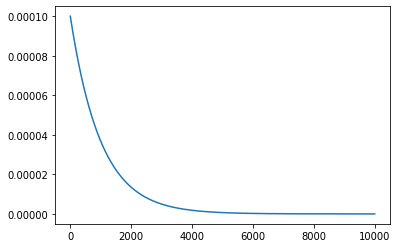

In [35]:
gamma_=0.999
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma_)
lrs = []

for i in range(10000):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)

In [36]:
if "output" not in os.listdir():
    !mkdir output

if not os.path.exists(f'./output/{modelname}/A'):
    os.makedirs(f'./output/{modelname}/A')
if not os.path.exists(f'./output/{modelname}/B'):
    os.makedirs(f'./output/{modelname}/B')

In [37]:
LAMBDA_CYCLE_ab = 10
LAMBDA_ID_ab = 1
LAMBDA_GAN_ab = 1
LAMBDA_CYCLE_ba = 10
LAMBDA_ID_ba =  1
LAMBDA_GAN_ba = 1 

LAMBDA_DISC = 0.5

In [38]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [39]:
# Lossess
criterion_GAN = torch.nn.MSELoss()

criterion_cycle = nn.CrossEntropyLoss (ignore_index=0)
criterion_identity = nn.CrossEntropyLoss (ignore_index=0)

optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lrg, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lrd, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lrd, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor #if device=='cuda' else torch.Tensor

if n_seq>1:
    target_real = Variable(Tensor(BATCH_SIZE, n_seq).fill_(1.0), requires_grad=False).to(device)
    target_fake = Variable(Tensor(BATCH_SIZE, n_seq).fill_(0.0), requires_grad=False).to(device)
else:
    target_real = Variable(Tensor(BATCH_SIZE).fill_(1.0), requires_grad=False).to(device)
    target_fake = Variable(Tensor(BATCH_SIZE).fill_(0.0), requires_grad=False).to(device)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [40]:
def write_MIDI (x, fname='output.mid', xoffset=0):
    
    mf = MIDIFile(1)     
    track = 0  

    time = 0   
    mf.addTrackName(track, time, fname)
    mf.addTempo(track, time, 120)

    channel = 0
    volume = 100

    for i in range (x.shape[0]):
        pitch =int ( x[i]+xoffset  )       
        time = i             
        duration = 1       
        mf.addNote(track, channel, pitch, time, duration, volume)

    with open(fname, 'wb') as outf:
        mf.writeFile(outf)    

In [41]:
def validation_sampling (dataloader, num_samples=4,  numbins=20, tag=0, 
                         data1='music', data2='protein', elements='note #/residue #',
                        Note='Note', AA='AA', Note_AA='Note/AA',
                        plot_generated=True,
                        ):
    netG_A2B.eval()
    netG_B2A.eval()
    acc_A_list=[]
    acc_B_list=[]
    acc_tot_list=[]
    print (f"Produce {num_samples} samples...")
    
    A_or_l=[] 
    A_recov_l=[]
    A_fake_l=[]
    B_or_l=[]
    B_recov_l=[]
    B_fake_l=[]

    for idx, batch in  enumerate(tqdm.tqdm(dataloader)):
            torch.cuda.empty_cache()

            x_img = batch['A']#.cuda()
            y_img = batch['B']#.cuda()

            print (idx, x_img.shape, y_img.shape)
            
            with torch.no_grad():
                
                fig, axs = plt.subplots(5, 1,  tight_layout=True, figsize=(6,22)) #sharey=True,

                fake_B=netG_A2B(x_img.to(device)) 
                fake_A=netG_B2A(y_img.to(device))
                
                axs[0].plot ( y_img.cpu().numpy()[0], label =f'Source ({data2})')
                axs[0].plot (fake_A.cpu().numpy()[0], label = f'Prediction ({data1})')
                axs[0].legend ()
                axs[0].set_xlabel (f'{elements}')
                axs[0].set_ylabel (f'{Note_AA}')
                axs[0].title.set_text  (f'{data2} to {data1}')

            
                print ("write original MIDI source music")
                write_MIDI (x_img.cpu().numpy()[0], fname=f"./output/{modelname}/MIDI_sample_{idx}_{tag+100}.mid", 
                            xoffset=music_shift_token)
                
                print ("write translated music from protein")
                write_MIDI (fake_A.cpu().numpy()[0], fname=f"./output/{modelname}/MIDI_sample_{idx}_{tag}.mid", 
                            xoffset=music_shift_token)
                
                axs[1].plot ( x_img.cpu().numpy()[0], label =f'Source ({data1})')
                axs[1].plot (fake_B.cpu().numpy()[0], label = f'Prediction ({data2})')
                axs[1].title.set_text (f'{data1} to {data2}')
                axs[1].set_xlabel (f'{elements}')
                axs[1].set_ylabel (f'{Note_AA}')
                axs[1].legend ()
                
                predstr=map_rev(mapping_rev, fake_B.cpu().numpy()[0])

                print ("####\nPredicted protein sequence: \n",predstr, 
                       "\nTokenized version:\n",fake_B.cpu().numpy()[0],
                       "\nfrom: \n",  x_img.cpu().numpy()[0],"\n####")
                
                orstr=map_rev(mapping_rev, y_img.cpu().numpy()[0])

                print ("####\nOriginal protein sequence used to construct the music: \n",orstr, 
                       "\nTokenized version:\n",y_img.cpu().numpy()[0] ,"\n####")

                ################################ CYCLE ##################
               
                recovered_A= netG_B2A (fake_B)
                
                recovered_B= netG_A2B (fake_A)
                axs[2].plot ( x_img.cpu().numpy()[0],'o-', label =f'Source ({data1})')
                axs[2].plot (recovered_A.cpu().numpy()[0],'x-', label = f'Reconstruction ({data1})')
                axs[2].title.set_text (f'{data1} to {data1} cycle')
                axs[2].set_xlabel (f'{elements}')
                axs[2].set_ylabel (f'{Note_AA}')
                axs[2].legend ()

                axs[3].plot ( y_img.cpu().numpy()[0],'o-', label =f'Source ({data2})')
                axs[3].plot (recovered_B.cpu().numpy()[0],'x-', label = f'Reconstruction ({data2})' )
                axs[3].title.set_text (f'{data2} to {data2} cycle')
                axs[3].set_xlabel (f'{elements}')
                axs[3].set_ylabel (f'{Note_AA}')
                axs[3].legend () 

                error_A=x_img.cpu().numpy()[:].flatten()-recovered_A.cpu().numpy()[:].flatten()
                error_B=y_img.cpu().numpy()[:].flatten()-recovered_B.cpu().numpy()[:].flatten()
                error_A=np.abs (error_A)
                error_B=np.abs (error_B)

                error_A=np.where(error_A > 0.5, 1, 0)
                error_B=np.where(error_B > 0.5, 1, 0)

                axs[4].plot ( error_A,'o-', label =f'Reconstruction error ({data1})')
                axs[4].plot ( error_B,'x-', label = f'Reconstruction error ({data2})' )
                axs[4].title.set_text ('Reconstruction error')

                axs[4].set_xlabel (f'Across all {elements} in batch')
                axs[4].set_ylabel ('Error')
                axs[4].legend () 

                outname=f"./output/{modelname}/im_save_sampling_sample_{idx:06d}_{tag}.png"
                plt.savefig(outname, dpi=600)
                outname=f"./output/{modelname}/im_save_sampling_sample_{idx:06d}_{tag}.svg"
                plt.savefig(outname, dpi=200)

                plt.show ()

                avg_error_A=np.sum (error_A)/error_A.shape[0]

                avg_error_B=np.sum (error_B)/error_A.shape[0]

                avg_error_tot=( avg_error_A+avg_error_B )/2.

                acc_A_list.append (1-avg_error_A)
                acc_B_list.append (1-avg_error_B)
                acc_tot_list.append (1-avg_error_tot)

                 ### statistics- across batch
                fig, axs = plt.subplots(2, 1,  tight_layout=True, figsize=(6,10)) #sharey=True,

                if plot_generated:
                    axs[0].hist ([x_img.cpu().numpy()[:].flatten(), 
                              recovered_A.cpu().numpy()[:].flatten(),
                              fake_A.cpu().numpy()[:].flatten()],
                              label=[f'Original ({data1})',
                                                    f'Recovered ({data1})',
                                                     f'Generated ({data1}, from {data2})',
                                                    ] , bins=numbins, density=True)
                else:
                    axs[0].hist ([x_img.cpu().numpy()[:].flatten(), 
                              recovered_A.cpu().numpy()[:].flatten()],
                             # fake_A.cpu().numpy()[:].flatten()],
                              label=[f'Original ({data1})',
                                                    f'Recovered ({data1})',
                                                  ##   f'Generated ({data1}, from {data2})',
                                                    ] , bins=numbins, density=True)

                    
                
                axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
              
                axs[0].set_xlabel (f'{Note} histogram {data1} data')
                axs[0].legend () 
                if plot_generated:
                    axs[1].hist ([y_img.cpu().numpy()[:].flatten(), 
                                  recovered_B.cpu().numpy()[:].flatten(),
                                  fake_B.cpu().numpy()[:].flatten()],                                  
                                   label=[f'Original ({data2})',
                                                        f'Recovered ({data2})',
                                                         f'Generated ({data2}, from {data1})',
                                                        ], bins=numbins, density=True)

                else:
                    axs[1].hist ([y_img.cpu().numpy()[:].flatten(), 
                                  recovered_B.cpu().numpy()[:].flatten()],
                                  #fake_B.cpu().numpy()[:].flatten()],                                  
                                   label=[f'Original ({data2})',
                                                        f'Recovered ({data2})',
                                                        # f'Generated ({data2}, from {data1})',
                                                        ], bins=numbins, density=True)

               
                axs[1].set_xlabel (f'{AA} histogram {data2} data')
                axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
                axs[1].legend () 

                outname=f"./output/{modelname}/im_save_sampling_stats_sample_{idx:06d}_{tag}.png"
                plt.savefig(outname, dpi=200)
                outname=f"./output/{modelname}/im_save_sampling_stats_sample_{idx:06d}_{tag}.svg"
                plt.savefig(outname, dpi=200)
                plt.show()
                
                A_or_l.append (x_img.cpu().numpy()[:].flatten())
                A_recov_l.append (recovered_A.cpu().numpy()[:].flatten())
                A_fake_l.append (fake_A.cpu().numpy()[:].flatten())
                
                B_or_l.append( y_img.cpu().numpy()[:].flatten())
                B_recov_l.append (recovered_B.cpu().numpy()[:].flatten())
                B_fake_l.append (fake_B.cpu().numpy()[:].flatten())
                
                
            if idx>num_samples-2:
                break
          
    plt.plot ( acc_A_list, label =f'Reconstruction accuracy ({data1})')
    plt.plot ( acc_B_list, label =f'Reconstruction accuracy ({data2})')
    plt.plot ( acc_tot_list, label =f'Reconstruction accuracy (total)')

    plt.xlabel ('Steps')
    plt.ylabel ('Reconstruction accuracy')
    plt.legend ()
    
    avg_acc=sum (acc_tot_list)/len (acc_tot_list)
    avg_acc_A=sum (acc_A_list)/len (acc_A_list)
    avg_acc_B=sum (acc_B_list)/len (acc_B_list)
    
    print (f"Overall accuracy over all samples = {avg_acc}")
    print (f"Overall accuracy over all samples A, B = {avg_acc_A}, {avg_acc_B}")

    outname=f"./output/{modelname}/im_save_sampling_accurac_sample_{idx:06d}_{tag}.png"
    plt.savefig(outname, dpi=200)
    outname=f"./output/{modelname}/im_save_sampling_accurac_sample_{idx:06d}_{tag}.svg"
    plt.savefig(outname, dpi=200)
    plt.show()    
     
    A_or_l=np.asarray (A_or_l).flatten() #used for overall statistics
    A_recov_l=np.asarray (A_recov_l).flatten()
    A_fake_l=np.asarray (A_fake_l).flatten()
    B_or_l=np.asarray (B_or_l).flatten()
    B_recov_l=np.asarray (B_recov_l).flatten()
    B_fake_l=np.asarray (B_fake_l).flatten()
    fig, axs = plt.subplots(2, 1,  tight_layout=True, figsize=(6,10)) #sharey=True,

    axs[0].hist ([A_or_l, A_recov_l, A_fake_l],
                 label=[f'Original ({data1})',
                                        f'Recovered ({data1})',
                                         f'Generated ({data1}, from {data2})',
                                        ], bins=numbins, density=True )

    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
   
    axs[0].set_xlabel (f'Averaged note histogram {data1} data')
    axs[0].legend () 

    axs[1].hist ([B_or_l, B_recov_l, B_fake_l],                                  
                   label=[f'Original ({data2})',
                                        f'Recovered ({data2})',
                                         f'Generated ({data2}, from {data1})',
                                        ], bins=numbins, density=True)
   
    axs[1].set_xlabel (f'Averaged AA histogram {data2} data')
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].legend () 
 
    outname=f"./output/{modelname}/im_overall_sampling_stats_{idx:06d}_{tag}.png"
    plt.savefig(outname, dpi=200)
    outname=f"./output/{modelname}/im_overall_sampling_stats_{idx:06d}_{tag}.svg"
    plt.savefig(outname, dpi=200)
    plt.show()
    
    return acc_A_list,acc_B_list,acc_tot_list, avg_acc, avg_acc_A, avg_acc_B 

In [42]:
lr_scheduler_G = torch.optim.lr_scheduler.ExponentialLR(optimizer_G, gamma=gamma_)
lr_scheduler_D_A = torch.optim.lr_scheduler.ExponentialLR(optimizer_D_A, gamma=gamma_)
lr_scheduler_D_B = torch.optim.lr_scheduler.ExponentialLR(optimizer_D_B, gamma=gamma_)

In [43]:
print_every   = 5

lossg_c=[]
lossg_ident_c=[]
loss_disc_a_c =[]
loss_disc_b_c =[]
 
steps=[]

acc_A_list=[]
acc_B_list=[]
acc_tot_list=[]
acc_stdev_list=[]
lrg_list=[]
lrd_list=[]

#### Tokenizer and reverse function

In [52]:
vocab_seqs=['', '[UNK]', 'L', 'A', 'G', 'E', 'V', 'S', 'D', 'K', 'I', 'T', 'R', 'P', 'N', 'F', 'Q', 'Y', 'H', 'M', 'W', 'C', 'X', 'U', 'O']
mapping={x:i for i, x in enumerate(vocab_seqs)}
mapping_rev={mapping[k]:k for k in mapping}

def map_rev (mapping_rev, result):
    string="".join([mapping_rev[i] for i in result])
    return string

def alter(c):
    if c!="#":
        return c
    return "[UNK]"

def map_forward (mapping, string):
    string=string.replace("[UNK]","#")
    return [mapping[alter(c)] for c in string]

In [53]:
numbins_A=music_tokens
numbins_B=protein_tokens

save_chks = True
plot_losses=True
plot_sample=True

netG_A2B.train()
netG_B2A.train()

lossg=[]
lossg_ident=[]
loss_disc_a=[]
loss_disc_b=[]

In [46]:
train_model=False

if train_model:

    for epoch in range(epoch_start, n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")

        for idx, batch in  enumerate(tqdm.tqdm(dataloader)):
            if istep<warmup_steps:
                lrd_=lrd*(1 -(warmup_steps-istep)/warmup_steps)
                lrg_=lrg*(1 -(warmup_steps-istep)/warmup_steps)
                optimizer_D_A.param_groups[0]['lr']=lrd_
                optimizer_D_A.param_groups[0]['lr']=lrd_
                optimizer_G.param_groups[0]['lr']=lrg_


            torch.cuda.empty_cache()

            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)

            ###### Generators A2B and B2A ######
            optimizer_G.zero_grad()

            # Identity loss
            _, same_B = netG_A2B(real_B, return_one_hot=True)
            loss_identity_B = criterion_identity(same_B, real_B.transpose(0, 1).long().reshape(-1))*LAMBDA_ID_ab
            _,  same_A = netG_B2A(real_A, return_one_hot=True)
            loss_identity_A = criterion_identity(same_A, real_A.transpose(0, 1).long().reshape(-1))*LAMBDA_ID_ba

            # GAN loss
            fake_B = netG_A2B(real_A)
            pred_fake = netD_B(fake_B)
            loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

            fake_A = netG_B2A(real_B)
            pred_fake = netD_A(fake_A)
            loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

            # Cycle loss
            _, recovered_A = netG_B2A(fake_B, return_one_hot=True) 
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A.transpose(0, 1).long().reshape(-1))*LAMBDA_CYCLE_ab

            _, recovered_B = netG_A2B(fake_A, return_one_hot=True)
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B.transpose(0, 1).long().reshape(-1))*LAMBDA_CYCLE_ba

            # Total loss
            loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            loss_G.backward()
            torch.nn.utils.clip_grad_norm_(netG_B2A.parameters(), 0.5)
            torch.nn.utils.clip_grad_norm_(netG_A2B.parameters(), 0.5)

            optimizer_G.step()

            ###### Discriminator A ######
            optimizer_D_A.zero_grad()

            # Real loss
            pred_real = netD_A(real_A)
            loss_D_real = criterion_GAN(pred_real, target_real)

            # Fake loss
            fake_A = fake_A_buffer.push_and_pop(fake_A)
            pred_fake = netD_A(fake_A.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_A = (loss_D_real + loss_D_fake)*LAMBDA_DISC
            loss_D_A.backward()
            torch.nn.utils.clip_grad_norm_(netD_A.parameters(), 0.5)
            optimizer_D_A.step()
            ###################################

            ###### Discriminator B ######
            optimizer_D_B.zero_grad()

            # Real loss
            pred_real = netD_B(real_B)
            loss_D_real = criterion_GAN(pred_real, target_real)

            # Fake loss
            fake_B = fake_B_buffer.push_and_pop(fake_B)
            pred_fake = netD_B(fake_B.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_B = (loss_D_real + loss_D_fake)*LAMBDA_DISC
            loss_D_B.backward()
            torch.nn.utils.clip_grad_norm_(netD_B.parameters(), 0.5)

            optimizer_D_B.step()
            ###################################

            lossg.append (loss_G.item())
            lossg_ident.append (loss_identity_A.item() + loss_identity_B.item())
            loss_disc_a.append (loss_D_A.item())
            loss_disc_b.append (loss_D_B.item())

            istep=istep+1
            lr_scheduler_G.step()
            lr_scheduler_D_A.step()
            lr_scheduler_D_B.step() 

            if istep%print_every==0:

                lossg_=[float(item) for item in lossg]
                lossg_c.append (sum(lossg_)/len(lossg_))

                lossg_ident_=[float(item) for item in lossg_ident]
                lossg_ident_c.append (sum(lossg_ident_)/len(lossg_ident_))

                loss_disc_a_=[float(item) for item in loss_disc_a]
                loss_disc_a_c.append (sum(loss_disc_a_)/len(loss_disc_a_))

                loss_disc_b_=[float(item) for item in loss_disc_b]
                loss_disc_b_c.append (sum(loss_disc_b_)/len(loss_disc_b_))

                steps.append (istep)

                lossg=[]
                lossg_ident=[]
                loss_disc_a=[]
                loss_disc_b=[]

                print(f"Epoch={epoch+1}, step={istep}: loss G={sum(lossg_)/len(lossg_)},  \
                        loss disc A={sum(loss_disc_a_)/len(loss_disc_a_)}, \
                        loss disc B={sum(loss_disc_b_)/len(loss_disc_b_)}\
                      ")

                if plot_losses:

                    fig, axs = plt.subplots(4, 1,  tight_layout=True, figsize=(6,12)) #sharey=True,

                    axs[0].plot (steps, lossg_c )
                    axs[0].set_xlabel ('Steps')
                    axs[0].set_ylabel ('Loss generator total')

                    axs[1].plot (steps, lossg_ident_c )
                    axs[1].set_ylabel ('Identity loss')
                    axs[1].set_xlabel ('Steps')

                    axs[2].plot (steps, loss_disc_a_c )
                    axs[2].set_ylabel ('Loss Disciminator A')
                    axs[2].set_xlabel ('Steps')

                    axs[3].plot (steps, loss_disc_b_c )
                    axs[3].set_ylabel ('Loss Disciminator B')
                    axs[3].set_xlabel ('Steps')

                    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
                    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
                    axs[2].xaxis.set_major_locator(MaxNLocator(integer=True))
                    axs[3].xaxis.set_major_locator(MaxNLocator(integer=True))

                    outname=f"./output/{modelname}/im_save{istep:06d}.png"
                    plt.savefig(outname, dpi=200)
                    outname=f"./output/{modelname}/im_save{istep:06d}.svg"
                    plt.savefig(outname, dpi=200)
                    plt.show()

                if plot_sample:

                    _,_,_,avg_acc,avg_acc_A,avg_acc_B = validation_sampling (val_dataloader, 
                                                                             num_samples=2, numbins=10, 
                                                                             tag=istep,
                                                                            data1=data1, 
                                                                             data2=data2, 
                                                                             elements=elements,
                                                                        Note=Note, AA=AA,
                                                                             Note_AA=Note_AA)


                    acc_A_list.append (avg_acc_A)
                    acc_B_list.append (avg_acc_B)
                    acc_tot_list.append (avg_acc)
                    acc_stdev=statistics.pstdev([avg_acc,avg_acc_A,avg_acc_B])
                    acc_stdev_list.append (acc_stdev)

                    print (f"Reconstruction acc (across all batches): Recon_acc_A={avg_acc_A}, Recon_acc_B={avg_acc_B}, Total reconstruction accuraccy={avg_acc}")
                    print (f"Std dev of accuracy: {acc_stdev}")

                    max_val = max(acc_tot_list)
                    idx_max = acc_tot_list.index(max_val)
                    print (f"#################\nBest reconstruction accuracy={max_val}, \
                           found at step={steps[idx_max]}\n#################")

                    plt.plot (steps,acc_A_list, label =f'Reconstruction accuracy ({data1})')
                    plt.plot (steps,acc_B_list, label =f'Reconstruction accuracy ({data2})')
                    plt.plot (steps,acc_tot_list, label =f'Reconstruction accuracy (total)')


                    plt.xlabel ('Steps')
                    plt.ylabel ('Reconstruction accuracy')
                    plt.legend ()

                    outname=f"./output/{modelname}/im_save_accurac_sample_{istep:06d}.png"
                    plt.savefig(outname, dpi=200)
                    outname=f"./output/{modelname}/im_save_accurac_sample_{istep:06d}.svg"
                    plt.savefig(outname, dpi=200)
                    plt.show()

                    plt.plot (steps,acc_tot_list, label =f'Reconstruction accuracy')

                    plt.xlabel ('Steps')
                    plt.ylabel ('Reconstruction accuracy')
                    plt.legend ()

                    outname=f"./output/{modelname}/im_save_1_accurac_sample_{istep:06d}.png"
                    plt.savefig(outname, dpi=200)
                    outname=f"./output/{modelname}/im_save_1_accurac_sample_{istep:06d}.svg"
                    plt.savefig(outname, dpi=200)
                    plt.show()                

                    plt.plot (steps,acc_stdev_list, label =f'Reconstruction std dev')

                    plt.xlabel ('Steps')
                    plt.ylabel ('Reconstruction accuracy std dev')
                    plt.legend ()

                    outname=f"./output/{modelname}/im_save_1_accur_stdev_sample_{istep:06d}.png"
                    plt.savefig(outname, dpi=200)
                    outname=f"./output/{modelname}/im_save_1_accur_stdev_sample_{istep:06d}.svg"
                    plt.savefig(outname, dpi=200)
                    plt.show()                    

                if save_chks:
                    print (f"Save checkpoints at epoch={epoch+1}, step={istep:06d}")
                    torch.save(netG_A2B.state_dict(), f'./output/{modelname}/netG_A2B_E{istep:06d}.pth')
                    torch.save(netG_B2A.state_dict(), f'./output/{modelname}/netG_B2A_E{istep:06d}.pth')
                    torch.save(netD_A.state_dict(), f'./output/{modelname}/netD_A_E{istep:06d}.pth')
                    torch.save(netD_B.state_dict(), f'./output/{modelname}/netD_B_E{istep:06d}.pth')

                lrg_list.append(optimizer_G.param_groups[0]['lr'])
                lrd_list.append(optimizer_D_A.param_groups[0]['lr'])

                plt.plot (steps,lrg_list , 'o-', label = 'LR generators')
                plt.plot (steps,lrd_list , 'x-', label = 'LR discriminators')
                plt.legend()
                plt.xlabel ('Steps')
                outname=f"./output/{modelname}/im_LR_{istep:06d}.png"
                plt.savefig(outname, dpi=200)
                outname=f"./output/{modelname}/im_LR_{istep:06d}.svg"
                plt.savefig(outname, dpi=200)            

                plt.show()

In [47]:
if train_model:
    
    max_val = max(acc_tot_list)
    idx_max = acc_tot_list.index(max_val)
    print (f"Best reconstruction accuracy={max_val}, found at step={steps[idx_max]}")

    max_val = max(acc_B_list)
    idx_max = acc_B_list.index(max_val)
    print (f"Best reconstruction accuracy B={max_val}, found at step={steps[idx_max]}")

    max_val = max(acc_A_list)
    idx_max = acc_A_list.index(max_val)
    print (f"Best reconstruction accuracy A={max_val}, found at step={steps[idx_max]}")

    max_val = min(acc_stdev_list)
    idx_max = acc_stdev_list.index(max_val)
    print (f"Min std dev of reconstruction accuracy A={max_val}, found at step={steps[idx_max]}")

### Load checkpoint

In [48]:
#checkpoint: https://www.dropbox.com/s/6ipt5mmuc2ebjjs/V0.628_checkpoint_1010.zip?dl=0 

istep_reload=1010 

netG_A2B.load_state_dict(torch.load(f"./output/{modelname}/netG_A2B_E{istep_reload:06d}.pth"))
netG_B2A.load_state_dict(torch.load(f"./output/{modelname}/netG_B2A_E{istep_reload:06d}.pth"))
netD_A.load_state_dict(torch.load(f"./output/{modelname}/netD_A_E{istep_reload:06d}.pth"))
netD_B.load_state_dict(torch.load(f"./output/{modelname}/netD_B_E{istep_reload:06d}.pth"))


<All keys matched successfully>

In [49]:
BATCH_SIZE_VAL=1024
val_dataloader = DataLoader(Text2TextDataset(X_test, 
                                         y_test,
                                          ), 
                                         batch_size=BATCH_SIZE_VAL, shuffle=False)#, num_workers=n_cpu)


print ("Number of val batches: ", len(val_dataloader), "batch size= ", BATCH_SIZE_VAL, "total: ",len(val_dataloader)*BATCH_SIZE_VAL )

Number of data in A=1439 and B=1439
Number of val batches:  2 batch size=  1024 total:  2048


Produce 1 samples...


  0%|          | 0/2 [00:00<?, ?it/s]

0 torch.Size([1024, 256]) torch.Size([1024, 256])
write original MIDI source music
write translated music from protein
####
Predicted protein sequence: 
 GASALTEKAKQSQMYMPRPAKVTLKAAKVTLKAAKVTLKAEHNKAKTGTATAGVGFLFVKVATALKATGVSSNYNSNSSNSANSADASAESAELSGLRLTLVPLLGTRVEVRVLRVRKVLKGKLKQLKRKGINTNINDINKNTRVTVRVLHSDQSQLKLQLNFQNQLKNWNILITGTWHWLDGGLGHYHDQDVKVSLSASADNDANKNGLGNKLGPLTGLGTNINTGSLELLTENTNTGYSLSGLGPELSLLTGEA 
Tokenized version:
 [ 4  3  7  3  2 11  5  9  3  9 16  7 16 19 17 19 13 12 13  3  9  6 11  2
  9  3  3  9  6 11  2  9  3  3  9  6 11  2  9  3  5 18 14  9  3  9 11  4
 11  3 11  3  4  6  4 15  2 15  6  9  6  3 11  3  2  9  3 11  4  6  7  7
 14 17 14  7 14  7  7 14  7  3 14  7  3  8  3  7  3  5  7  3  5  2  7  4
  2 12  2 11  2  6 13  2  2  4 11 12  6  5  6 12  6  2 12  6 12  9  6  2
  9  4  9  2  9 16  2  9 12  9  4 10 14 11 14 10 14  8 10 14  9 14 11 12
  6 11  6 12  6  2 18  7  8 16  7 16  2  9  2 16  2 14 15 16 14 16  2  9
 14 20 14 10  2 10 11  4 11 20 18 20  2  8  4  4  2  4 18

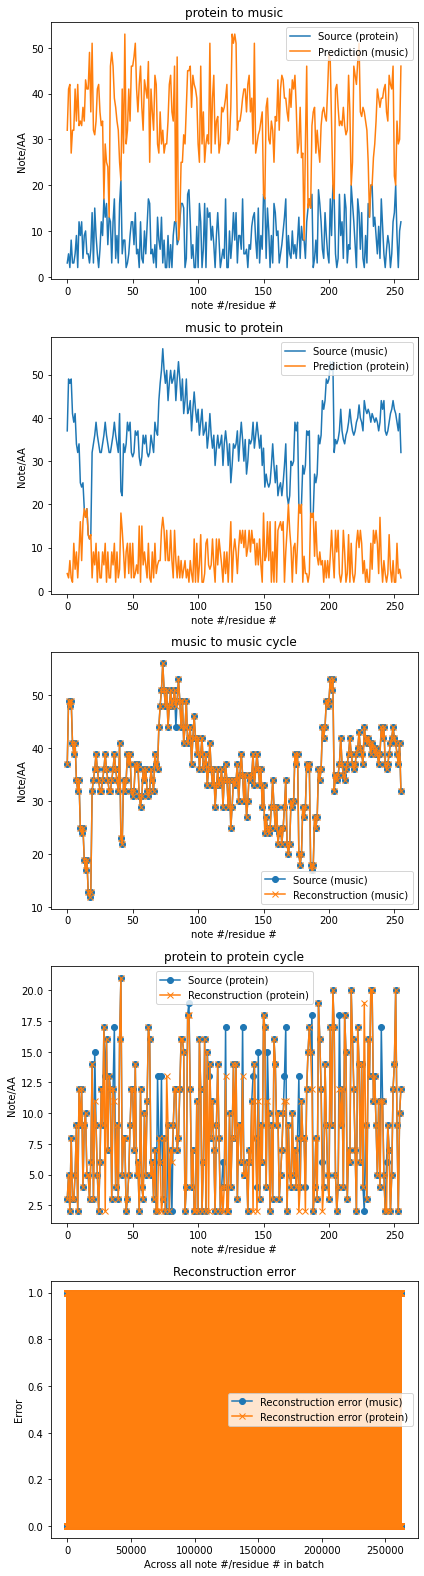

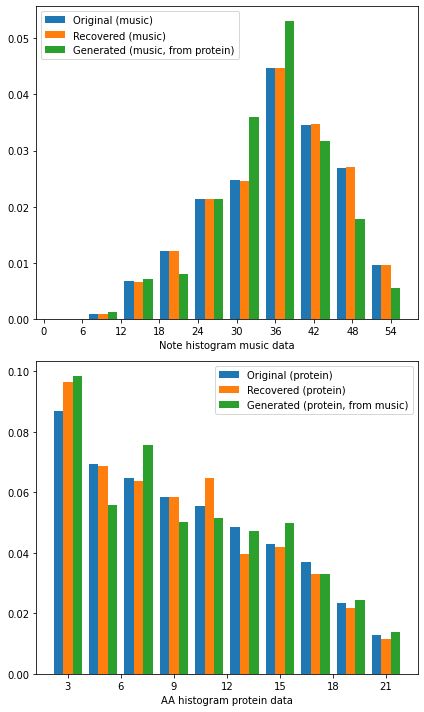

  0%|          | 0/2 [00:59<?, ?it/s]


Overall accuracy over all samples = 0.9531402587890625
Overall accuracy over all samples A, B = 0.9911231994628906, 0.9151573181152344


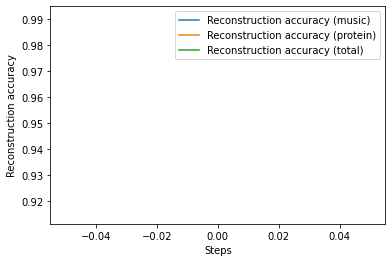

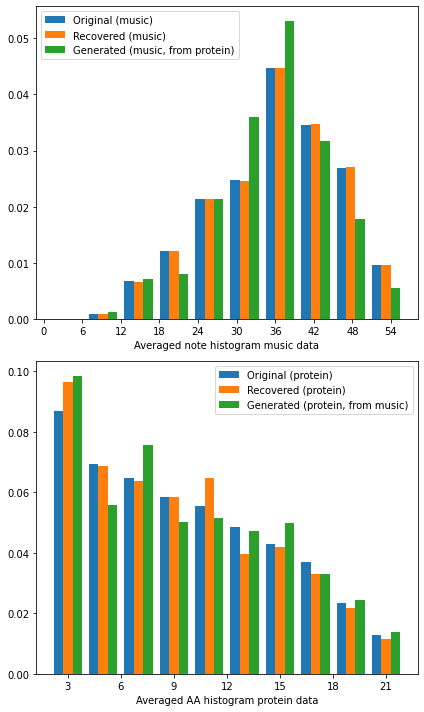

In [54]:
_,_,_,avg_acc,_,_ = validation_sampling (val_dataloader, num_samples=1, numbins=10,
                                        data1=data1, 
                                         data2=data2, 
                                         elements=elements,
                                    Note=Note, AA=AA,
                                         Note_AA=Note_AA)

In [95]:
BATCH_SIZE_VAL=128
val_dataloader = DataLoader(Text2TextDataset(X_test, 
                                         y_test,
                                          ), 
                                         batch_size=BATCH_SIZE_VAL, shuffle=False)#, num_workers=n_cpu)


print ("Number of val batches: ", len(val_dataloader), "batch size= ", BATCH_SIZE_VAL, "total: ",len(val_dataloader)*BATCH_SIZE_VAL )


Number of data in A=1439 and B=1439
Number of val batches:  12 batch size=  128 total:  1536


In [ ]:
_,_,_,avg_acc,_,_ = validation_sampling (val_dataloader, num_samples=12, numbins=10,
                                        data1=data1, 
                                         data2=data2, 
                                         elements=elements,
                                    Note=Note, AA=AA,
                                         Note_AA=Note_AA,
                                        plot_generated=False)

In [98]:
BATCH_SIZE_VAL=1
val_dataloader = DataLoader(Text2TextDataset(X_test, 
                                         y_test,
                                          ), 
                                         batch_size=BATCH_SIZE_VAL, shuffle=False)#, num_workers=n_cpu)


print ("Number of val batches: ", len(val_dataloader), "batch size= ", BATCH_SIZE_VAL, "total: ",len(val_dataloader)*BATCH_SIZE_VAL )

Number of data in A=1439 and B=1439
Number of val batches:  1439 batch size=  1 total:  1439


Produce 12 samples...


  0%|          | 0/1439 [00:00<?, ?it/s]

0 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_0_100.mid
[37 42 46 42 49 46 42 44 42 41 39 36 32 36 39 36 44 39 36 39 37 36 37 32
 29 32 37 32 41 37 44 42 41 39 37 49 48 49 43 41 43 36 34 36 48 46 48 41
 39 41 34 32 34 46 44 46 37 36 37 31 29 31 22 20 22 15 13 15 12 10 12 44
 42 25 27 29 32 29 27 25 25 27 28 32 28 27 25 26 27 29 32 29 27 26 27 31
 29 31 24 22 24 29 27 29 22 20 22 27 25 27 20 19 20 22 24 25 27 25 24 22
 20 24 15 20  8 20 53 54 56 54 56 54 56 54 56 54 56 54 56 54 53 54 53 35
 34 35 39 37 35 34 48 51 45 46 48 41 17 15 13 15 17 15 17 15 17 15 17 15
 17 15 13 15 13 10 13 17 13 10 15  3 15 18 17 15 17 21 24 29 17 34 33 34
 37 41 46 45 46 18 17 18 27 26 27 34 32 34 17 15 17 25 24 25 32 30 32 15
 13 15 22 20 22 30 29 30 39 37 39 48 46 48 51 49 51 37 39 41 44 41 39 37
 37 39 41 44 41 39 37 37 39 41 44 41 39 37 42 27]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

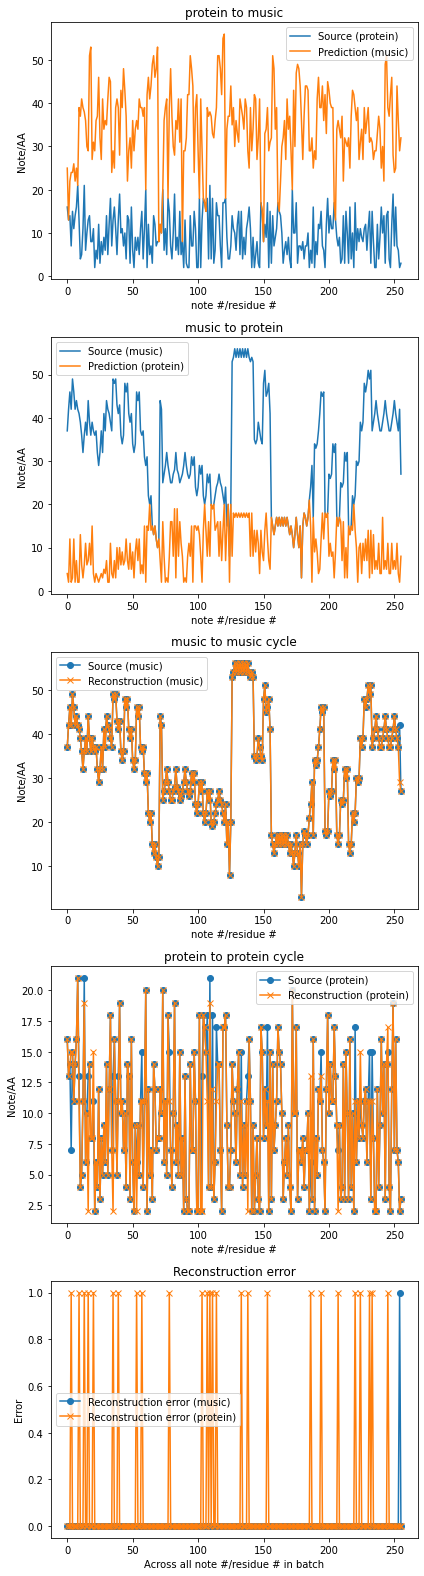

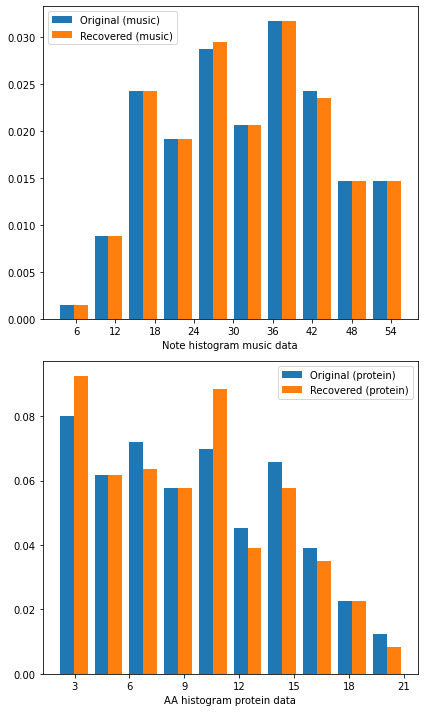

  0%|          | 1/1439 [00:04<1:51:52,  4.67s/it]

1 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_1_100.mid
[19 20 19 20 17 22 15 27 29 27 25 24 22 20 24 27 30 29 27 25 27 25 24 22
 20 19 22 25 29 27 25 24 27 25 24 25 27 25 24 22 20 19 20 17 20 19 20 19
 20 19 20 19 20 19 17 19 20 12 15  8 25 27 29 30 32 34 32 30 32 34 24 32
 22 24 25 27 29 30 32 30 29 30 30 24 29 30 29 27 25 24 22 25 29 32 30 29
 27 29 27 25 24 22 20 24 27 30 29 27 25 29 27 25 27 29 18 30 34 32 30 29
 27 29 30 32 29 30 32 25 24 25 25 24 22 20 19 17 19 20 19 20 17 22 15 27
 29 27 25 24 22 20 24 27 30 29 27 25 27 25 24 22 20 19 22 25 29 27 25 24
 27 25 24 25 27 25 24 22 20 19 20 17 20 19 20 19 20 19 20 19 20 19 17 19
 20 12 15  8 37 36 34 32 30 29 30 32 30 29 37 27 36 41 42 41 39 37 36 37
 39 37 36 34 32 30 34 32 30 32 34 27 25 27 30 29 27 29 34 29 25 22 25 19
 21 22 25 24 22 24 25 24 25 24 25 24 22 24 25 27]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

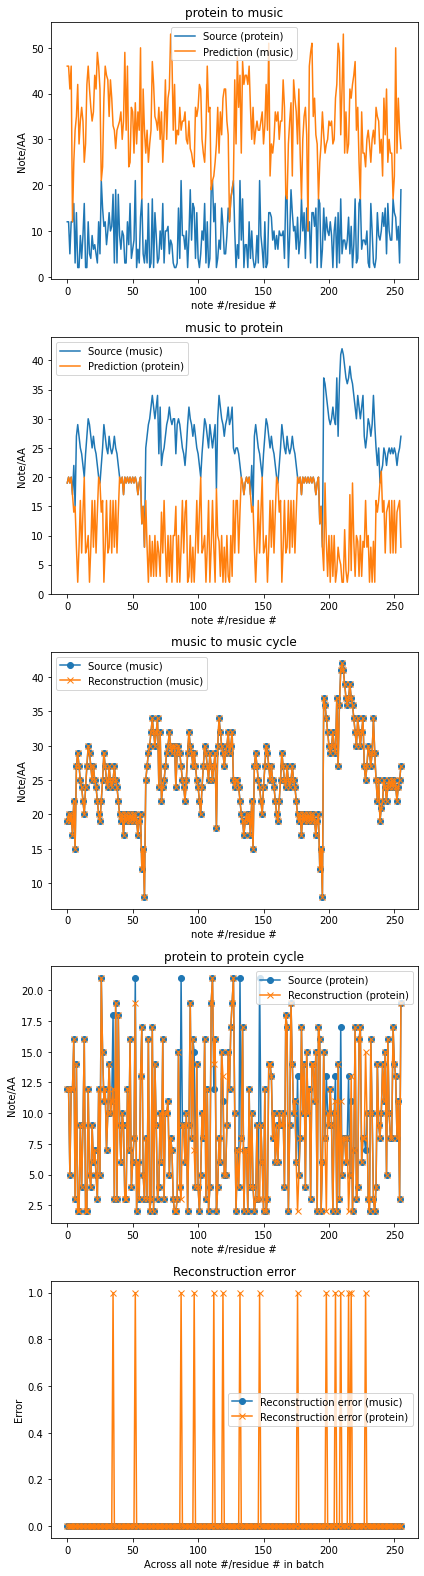

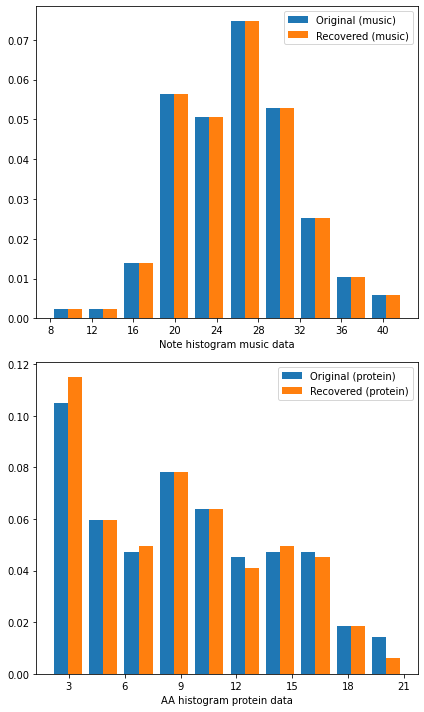

  0%|          | 2/1439 [00:09<1:55:53,  4.84s/it]

2 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_2_100.mid
[49 46 45 46 41 37 36 37 34 37 41 44 43 37 36 37 34 31 29 31 27 31 34 37
 32 34 32 34 32 34 32 32 34 32 34 32 34 32 32 34 32 34 32 34 32 32 34 32
 34 32 34 32 32 34 32 34 32 34 32 32 34 32 34 32 34 32 32 34 32 34 32 34
 32 32 34 32 34 32 34 32 31 32 31 32 31 32 31 36 32 31 32 27 24 22 24 20
 36 39 37 39 44 48 46 48 51 48 42 39 41 44 42 44 49 53 51 53 56 53 47 44
 46 41 42 33 34 25 24 46 45 48 46 48 51 48 45 48 41 43 45 46 45 46 43 41
 39 37 39 37 39 37 39 37 37 39 37 39 37 39 37 37 39 37 39 37 39 37 37 39
 37 39 37 39 37 37 39 37 39 37 39 37 37 39 37 39 37 39 37 34 32 34 36 34
 36 37 39 37 39 37 39 37 36 37 36 37 36 37 36 35 37 35 37 35 37 35 30 32
 30 32 30 32 30 29 30 29 30 29 30 29 28 30 28 30 28 30 28 36 39 37 39 44
 48 46 48 51 48 42 39 41 44 42 44 49 53 51 53 56]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

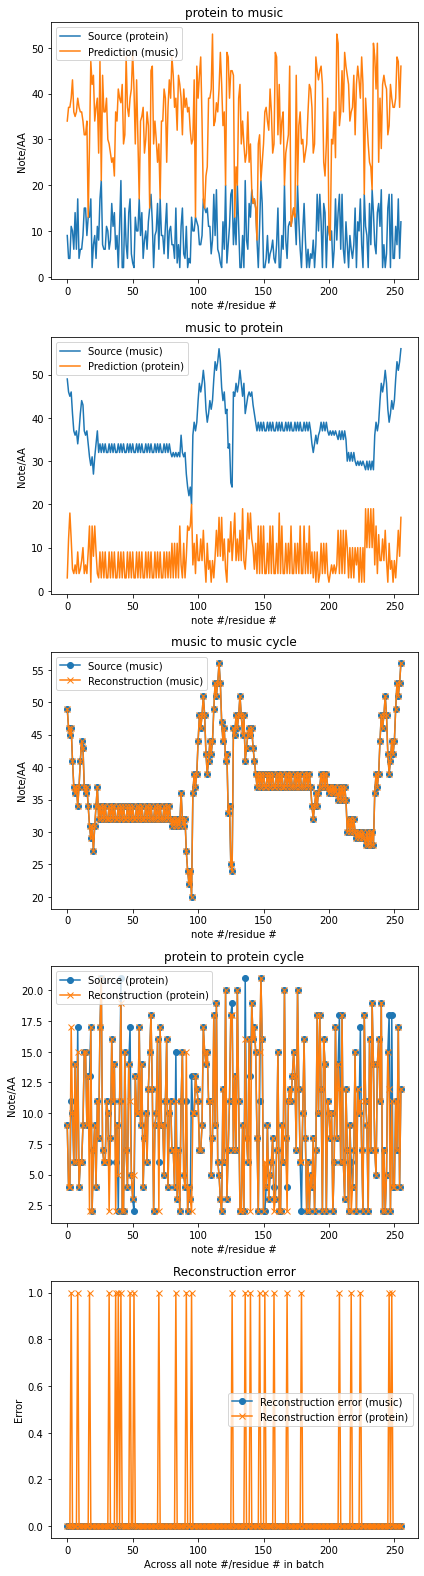

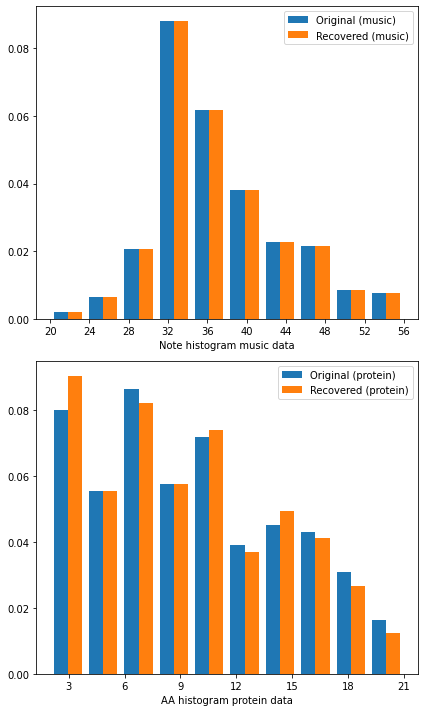

  0%|          | 3/1439 [00:14<1:57:12,  4.90s/it]

3 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_3_100.mid
[44 48 51 42 41 49 39 48 37 46 35 44 34 42 32 41 42 34 41 32 39 30 37 29
 36 27 34 25 27 36 25 34 24 32 22 30 20 29 18 27 17 15 17 15 17 20 25 24
 25 44 53 42 51 41 49 39 48 37 46 36 44 34 44 43 41 43 46 51 51 49 51 41
 49 39 48 37 46 36 44 34 43 32 41 31 41 39 38 39 43 46 46 44 46 44 46 43
 44 41 42 39 41 37 39 36 37 46 36 44 34 43 44 43 41 43 41 39 41 49 49 48
 46 48 44 41 37 39 36 37 46 36 34 36 34 36 39 44 43 44 51 48 49 46 48 44
 46 42 44 41 42 39 41 37 39 36 37 34 36 33 34 30 32 29 30 27 29 26 27 24
 25 22 23 21 22 19 21 19 21 19 21 24 29 27 25 29 27 30 29 33 31 34 33 36
 34 37 36 39 37 41 39 42 41 44 42 46 45 48 46 49 48 51 49 53 51 54 53 49
 51 48 49 46 48 45 46 42 41 39 37 36 34 46 41 44 42 41 39 42 41 44 42 46
 44 41 39 42 41 39 38 41 39 42 41 44 42 39 37 41]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

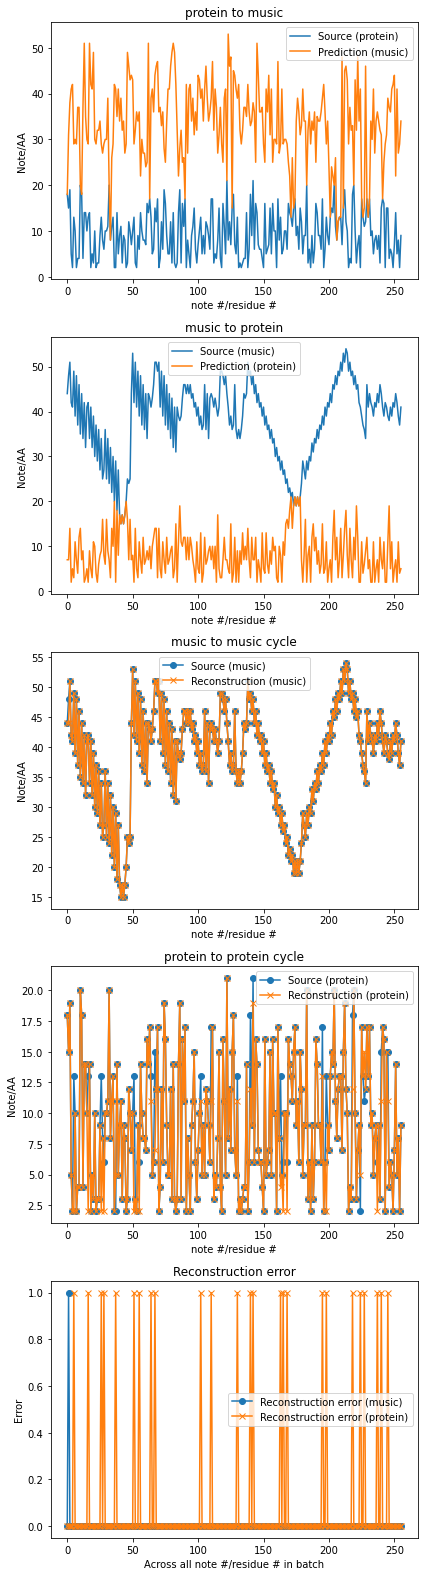

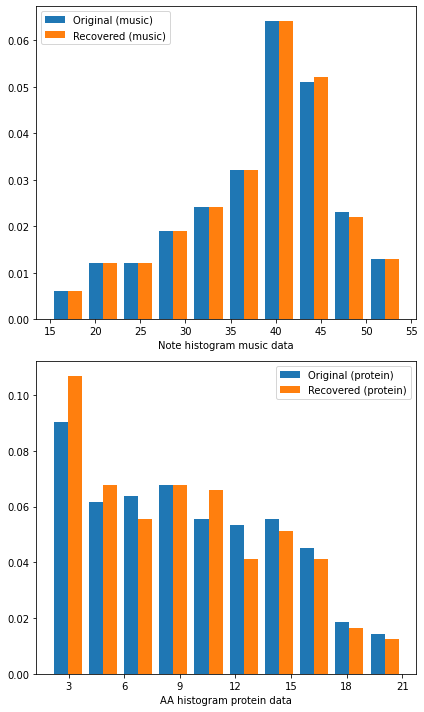

  0%|          | 4/1439 [00:19<1:57:13,  4.90s/it]

4 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_4_100.mid
[46 44 44 46 44 46 44 46 44 44 46 44 46 44 46 44 44 46 44 46 44 46 44 44
 46 44 46 44 46 44 44 46 44 46 44 46 44 43 44 43 44 43 44 43 44 46 44 46
 44 46 44 44 46 44 46 44 46 44 44 46 44 46 44 46 44 41 42 51 53 27 29 22
 24 54 53 51 49 39 48 41 53 49 48 49 46 41 39 41 37 41 46 49 51 48 46 48
 44 39 37 39 36 39 44 48 49 46 45 46 41 37 36 37 34 37 41 44 43 37 36 37
 34 31 29 31 27 31 34 37 32 34 32 34 32 34 32 32 34 32 34 32 34 32 32 34
 32 34 32 34 32 32 34 32 34 32 34 32 32 34 32 34 32 34 32 32 34 32 34 32
 34 32 32 34 32 34 32 34 32 32 34 32 34 32 34 32 31 32 31 32 31 32 31 36
 32 31 32 27 24 22 24 20 44 46 44 46 44 46 44 44 46 44 46 44 46 44 44 46
 44 46 44 46 44 44 46 44 46 44 46 44 44 46 44 46 44 46 44 44 46 44 46 44
 46 44 44 46 44 46 44 46 44 44 46 44 46 44 46 44]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

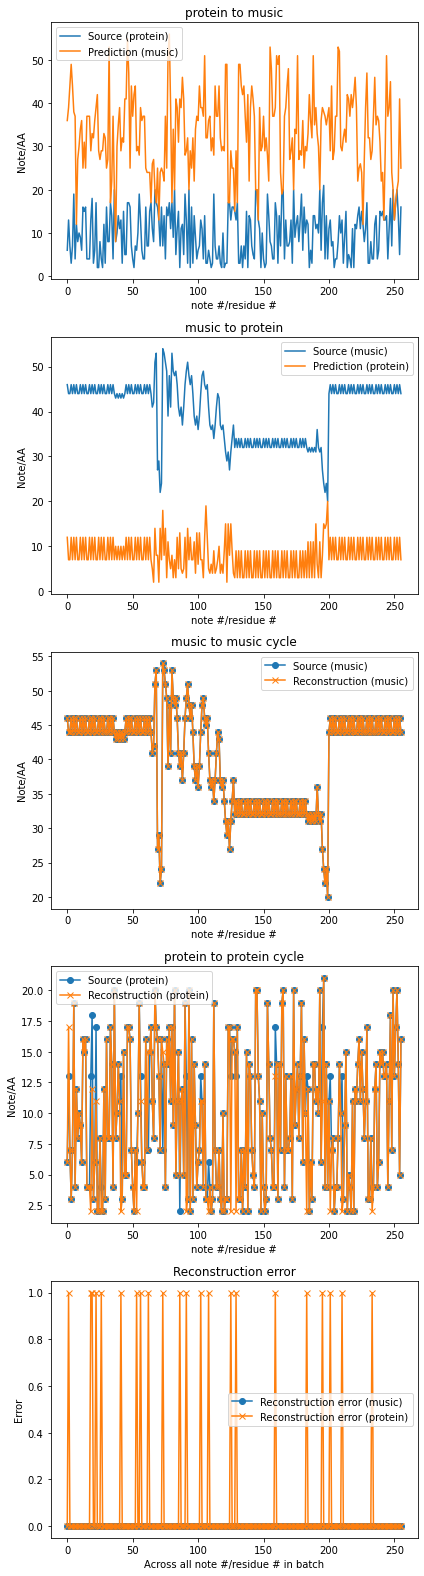

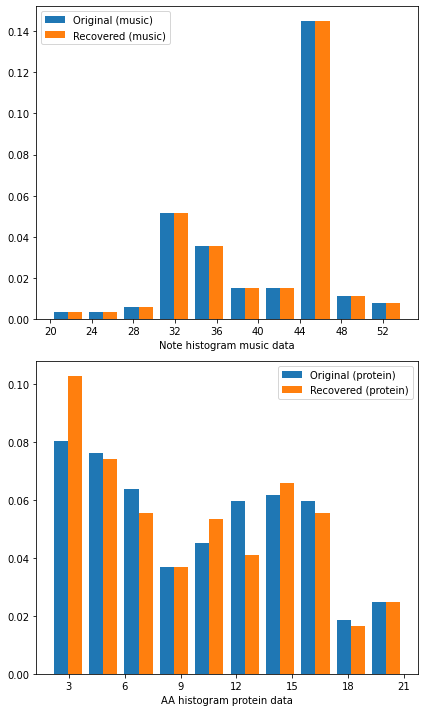

  0%|          | 5/1439 [00:24<1:55:30,  4.83s/it]

5 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_5_100.mid
[39 37 44 46 44 43 44 43 44 46 48 49 51 49 48 46 44 49 51 49 48 49 48 46
 48 49 46 39 53 51 49 49 48 46 48 46 44 43 44 46 48 49 51 53 54 53 51 49
 47 46 47 46 47 44 49 51 53 54 56 54 53 51 49 47 46 44 44 46 44 42 41 42
 44 46 44 49 46 42 41 39 37 39 37 39 41 42 36 37 39 32 36 34 32 39 37 36
 42 42 41 39 41 39 37 36 37 41 44 48 49 48 46 44 48 51 53 54 53 51 49 48
 46 45 46 48 49 51 53 49 48 46 51 49 48 46 44 43 44 46 48 49 51 48 46 44
 49 51 53 51 49 48 46 48 49 48 46 44 43 44 46 44 43 41 41 39 41 39 41 39
 41 39 41 39 41 39 41 39 41 39 43 41 39 41 43 44 46 48 51 49 48 49 51 44
 43 44 46 44 43 44 39 44 37 44 36 44 34 44 36 44 39 44 36 44 32 42 41 44
 43 44 46 44 43 44 41 44 39 44 37 44 36 44 37 44 41 44 37 44 34 44 43 37
 36 37 39 37 36 37 46 43 41 43 44 43 41 43 49 46]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

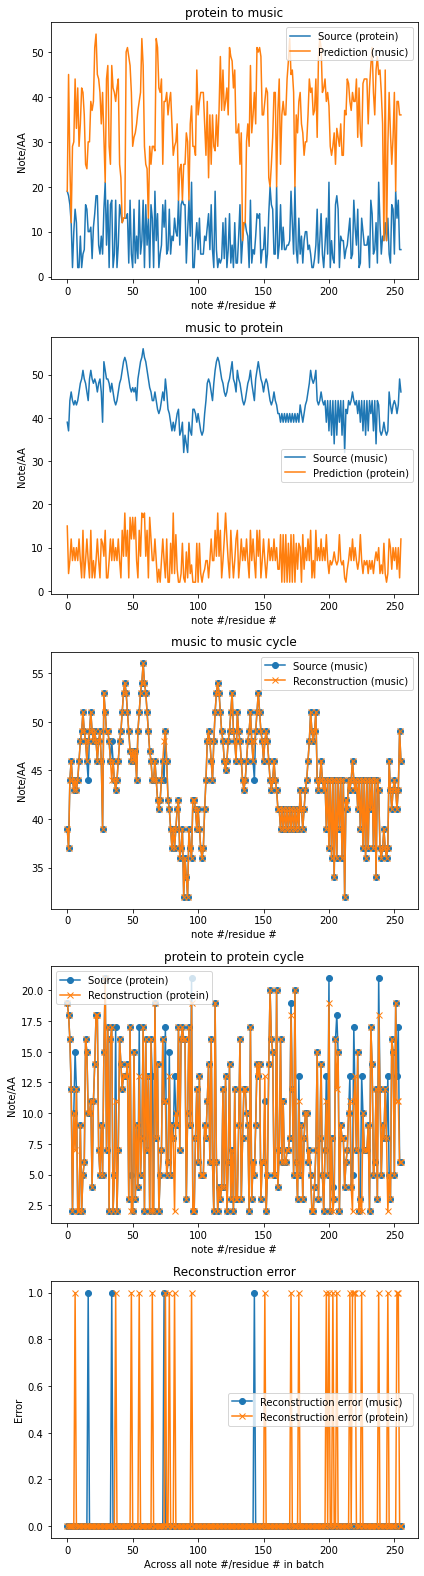

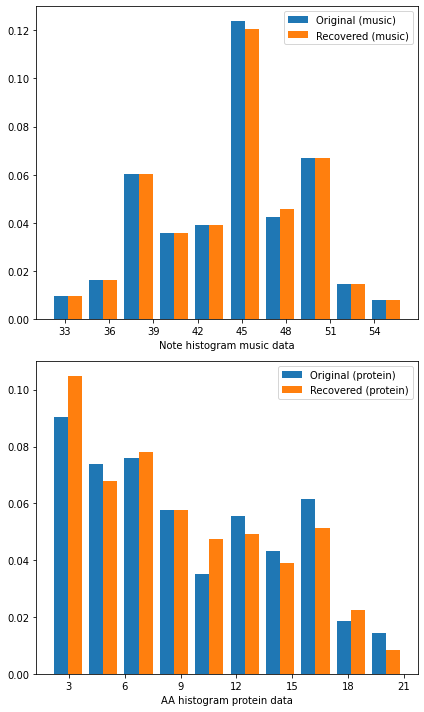

  0%|          | 6/1439 [00:29<1:57:43,  4.93s/it]

6 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_6_100.mid
[27 25 24 22 25 29 32 31 29 27 25 24 22 20 22 24 25 27 29 31 32 34 36 37
 39 39 37 39 37 39 37 39 37 39 37 39 37 29 32 37 36 37 39 37 39 37 39 37
 39 37 39 37 31 34 37 36 37 39 37 39 37 39 37 39 37 39 37 39 42 36 39 42
 41 37 32 29 25 29 32 37 39 41 39 37 36 34 32 31 34 39 37 36 34 32 31 29
 39 37 36 34 32 31 29 34 32 31 29 27 25 31 29 27 25 24 22 27 25 24 22 24
 25 24 27 32 36 39 44 39 36 32 30 29 27 26 29 32 35 41 44 41 35 34 32 31
 29 27 32 36 39 44 48 46 43 39 37 36 34 32 27 24 20 15 12  8 12 15 20 20
 22 24 25 27 29 30 20 30 29 27 25 27 29 30 32 34 35 25 35 34 32 30 34 37
 42 41 39 37 36 34 33 31 29 27 25 24 22 21 19 17 18 15 13 17 22 25 29 33
 34 13 15 18 23 27 30 33 34 16 17 19 21 22 24 25 27 25 24 25 22 25 29 34
 33 34 37 34 29 25 29 18 34 39 37 36 34 32 30 29]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

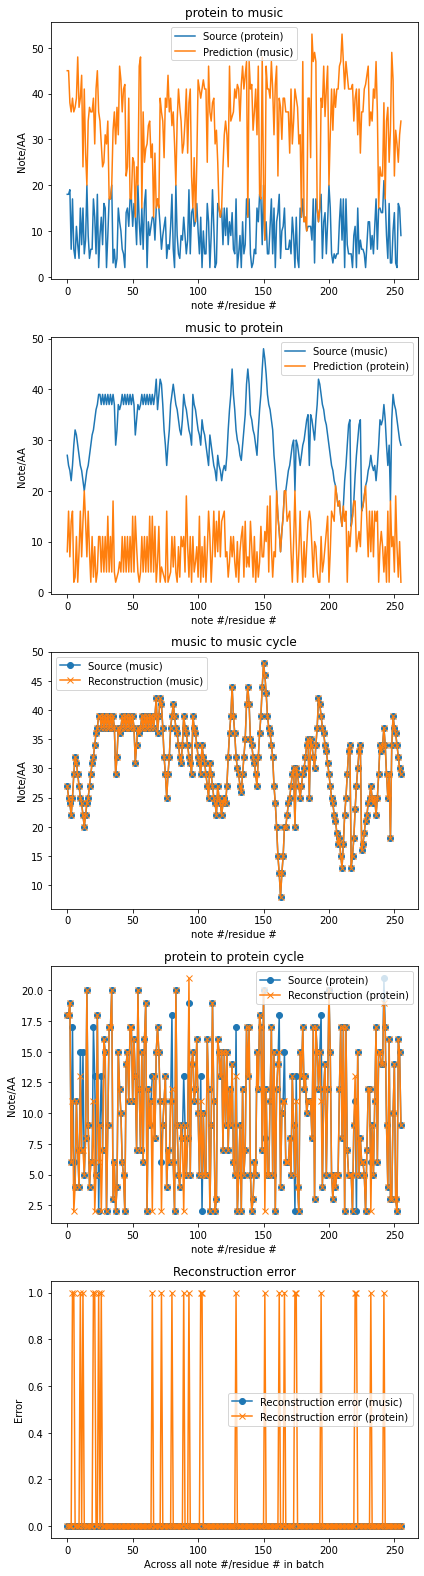

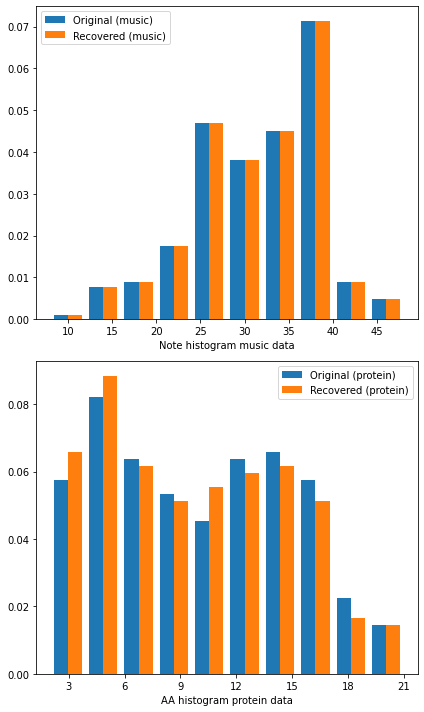

  0%|          | 7/1439 [00:34<1:57:39,  4.93s/it]

7 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_7_100.mid
[24 25 22 24 25 27 25 17 22 24 25 24 25 27 25 27 29 27 29 31 27 29 31 32
 31 22 27 29 31 29 31 32 31 32 34 32 34 36 32 34 36 34 36 39 37 39 32 31
 32 36 39 41 42 41 42 39 36 39 37 36 37 41 39 41 34 33 34 37 41 43 44 43
 44 41 37 41 43 41 43 46 44 46 39 38 39 43 46 48 49 48 49 46 43 46 48 46
 48 51 49 51 44 43 44 48 51 55 56 55 56 37 32 37 37 34 34 36 39 41 37 34
 27 32 32 30 29 30 32 25 30 22 25 24 25 27 20 25 13 13 15 13  8 10 12 13
 12 13 15 13 15 17 15 17 18 17 19 20 22 20 15 17 19 20 19 20 22 20 22 24
 22 24 25 22 24 25 27 25 17 22 24 25 24 25 27 25 27 29 27 29 31 27 29 31
 32 31 22 27 29 31 29 31 32 31 32 34 32 34 36 32 34 36 34 36 39 37 39 32
 31 32 36 39 41 42 41 42 39 36 39 37 36 37 41 39 41 34 33 34 37 41 43 44
 43 44 41 37 41 43 41 43 46 44 46 39 38 39 43 46]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

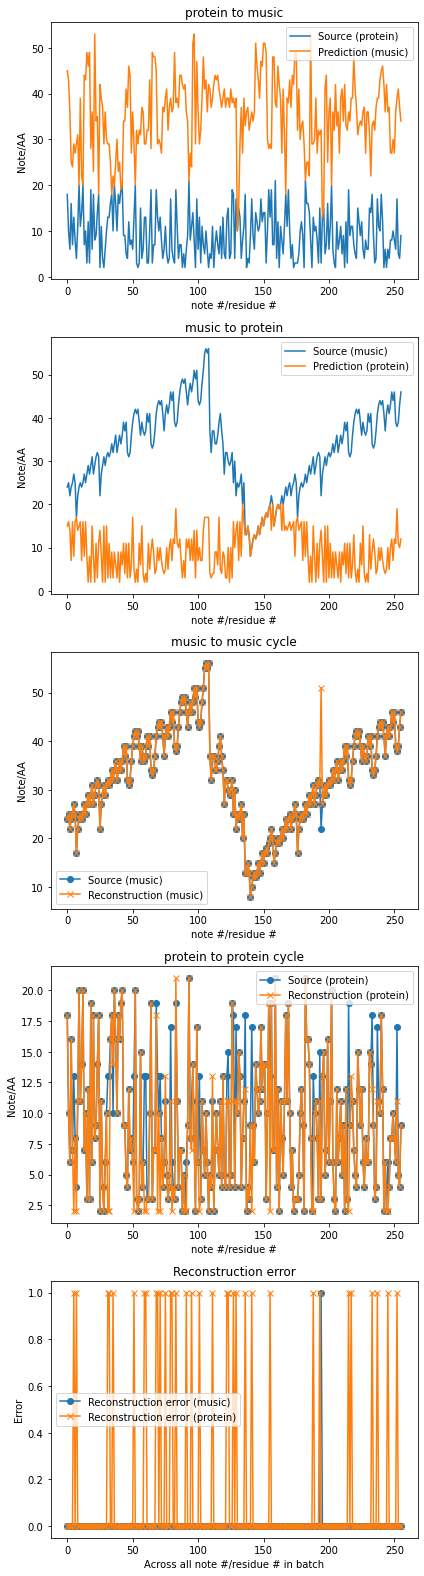

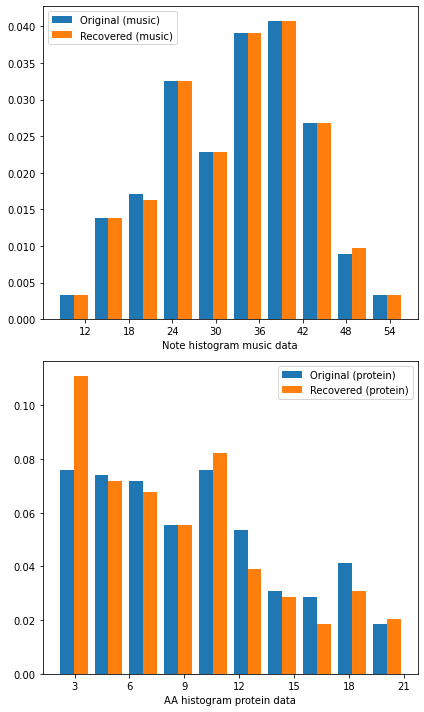

  1%|          | 8/1439 [00:39<1:56:56,  4.90s/it]

8 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_8_100.mid
[52 51 49 47 46 44 43 43 44 51 52 51 50 51 45 44 46 48 49 51 42 45 44 47
 49 47 45 47 38 37 39 41 42 44 35 38 37 42 41 42 45 43 42 47 45 47 45 44
 45 51 52 45 44 40 41 40 38 40 40 52 53 52 50 52 43 41 40 41 43 41 40 41
 41 53 46 45 44 45 55 54 45 44 41 40 46 45 44 47 50 53 52 50 48 47 45 44
 44 45 37 38 37 36 37 37 45 44 42 40 38 37 36 35 37 35 34 35 43 42 40 38
 36 35 34 33 35 33 32 33 42 40 38 37 36 45 44 43 43 44 33 32 34 36 37 39
 40 42 44 45 44 49 48 51 44 45 44 43 44 56 54 52 51 49 56 47 45 44 42 44
 50 49 47 45 44 42 41 42 47 45 44 42 40 39 37 39 44 42 40 39 37 36 34 36
 40 39 37 36 34 32 31 32 37 36 34 32 30 28 27 28 33 32 30 28 27 25 24 24
 25 51 52 51 50 51 45 44 46 48 49 51 42 45 44 47 49 47 45 47 38 37 39 41
 42 44 35 38 37 42 41 42 45 43 42 47 45 47 45 44]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

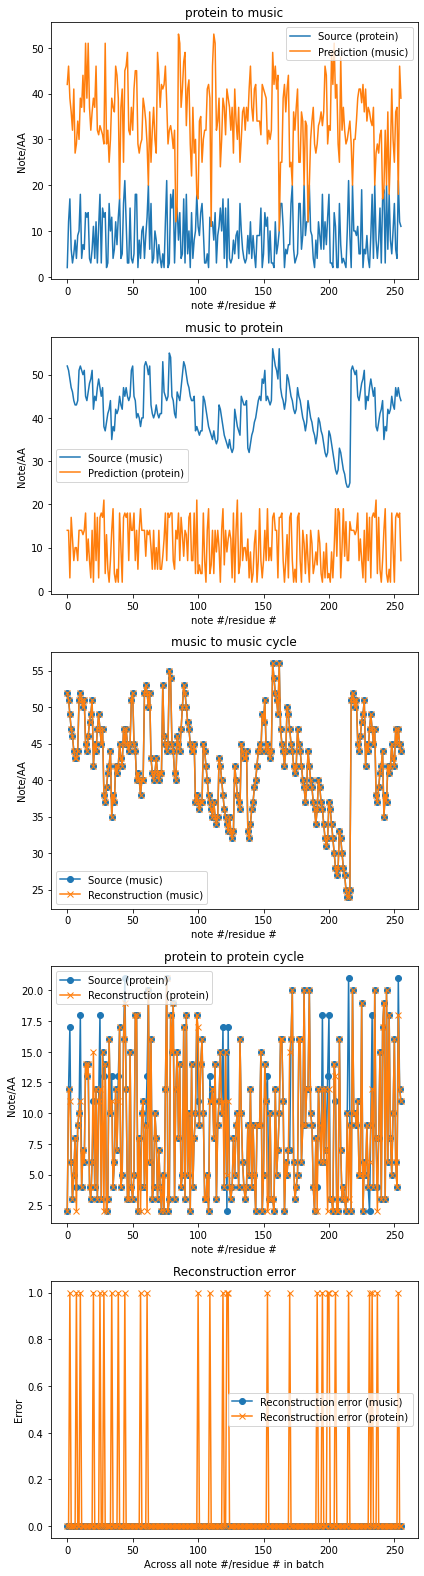

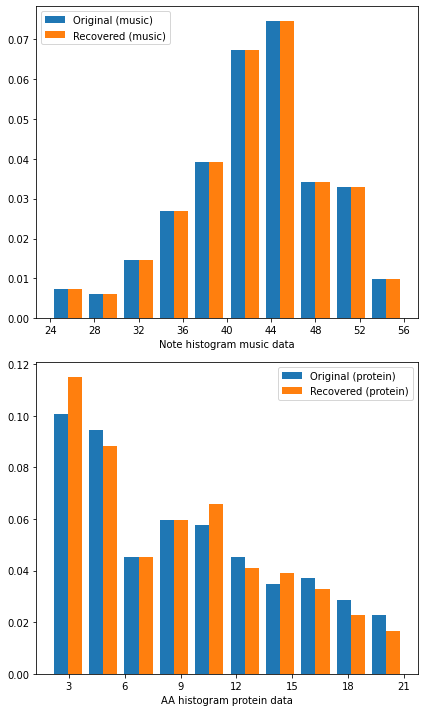

  1%|          | 9/1439 [00:44<1:57:03,  4.91s/it]

9 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_9_100.mid
[48 46 44 43 41 43 44 43 44 43 44 43 46 51 49 48 46 44 39 41 42 41 39 37
 36 34 44 43 44 46 44 43 41 39 49 41 43 43 44 46 44 43 43 44 49 49 51 49
 51 53 51 49 48 46 44 37 36 37 39 37 36 37 39 37 39 37 39 37 39 37 39 37
 36 37 39 37 36 37 36 34 34 32 44 44 46 44 46 47 46 44 42 41 39 49 48 46
 48 49 48 51 49 48 46 44 42 42 51 42 41 37 36 36 37 36 37 41 41 43 41 43
 44 44 43 41 39 37 41 46 49 51 49 48 49 51 49 51 49 51 49 51 49 51 49 48
 49 49 48 46 44 43 41 43 44 43 44 43 44 43 46 51 49 48 46 44 39 41 42 41
 39 37 36 34 44 43 44 46 44 43 41 39 49 41 43 43 44 46 44 43 43 44 39 37
 39 41 39 37 39 41 39 41 39 41 39 41 39 41 39 41 42 44 46 46 44 42 41 39
 37 49 48 46 48 45 45 46 45 46 51 53 51 49 51 48 46 45 41 46 48 49 48 48
 46 41 42 41 39 41 49 46 48 45 45 46 37 36 34 36]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628fi

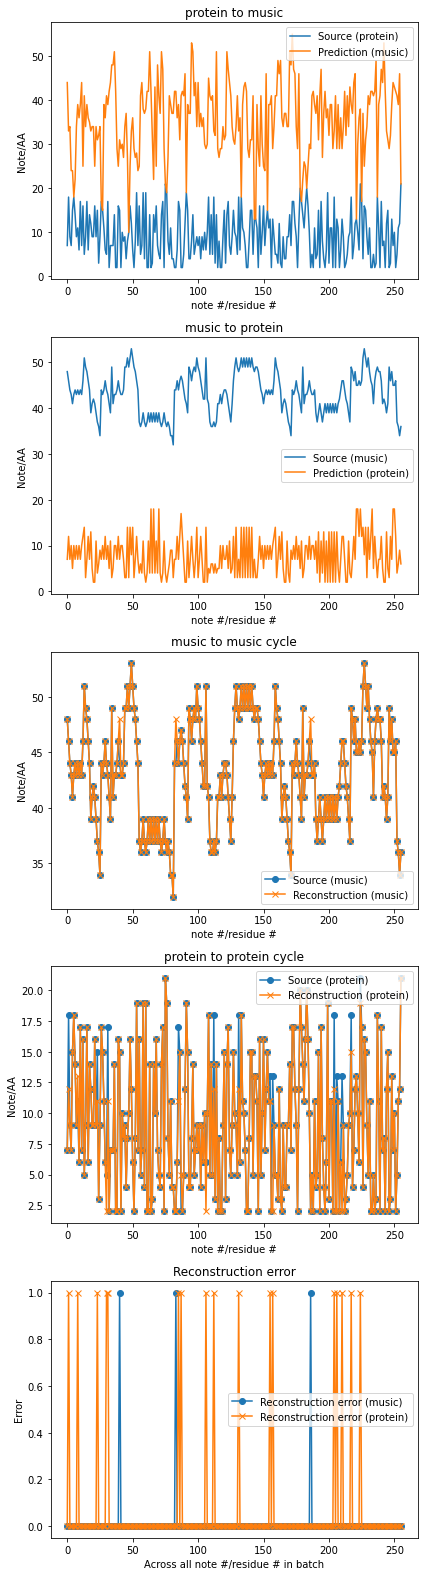

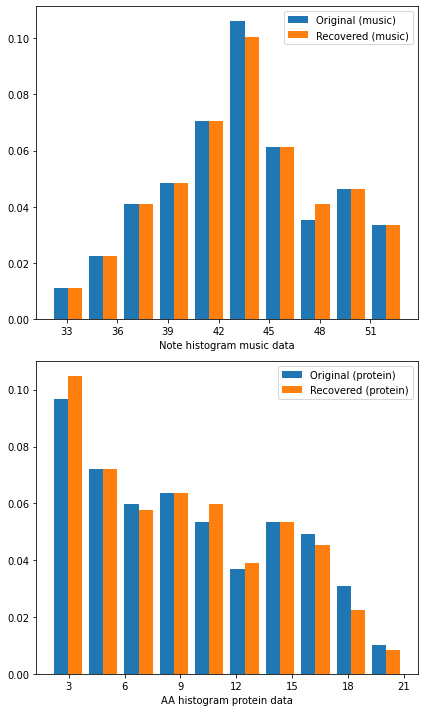

  1%|          | 10/1439 [00:48<1:55:53,  4.87s/it]

10 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_10_100.mid
[35 34 32 31 32 34 35 37 39 40 39 44 43 46 39 40 39 38 39 39 51 52 51 50
 51 44 42 40 42 42 40 39 39 40 42 40 39 40 40 52 45 44 43 44 54 53 44 43
 40 39 45 44 43 46 49 52 51 49 47 46 44 43 43 44 44 45 44 43 44 44 52 51
 49 47 45 44 43 42 44 42 41 42 42 50 49 47 45 43 42 41 40 42 40 39 40 48
 49 43 44 37 37 39 40 39 32 33 32 31 32 32 44 42 40 39 37 35 38 32 35 33
 35 33 32 33 33 45 44 42 40 39 37 40 34 37 36 37 36 34 36 41 42 45 43 44
 36 40 39 32 33 29 30 28 27 28 32 34 36 37 40 39 40 41 42 43 44 45 46 52
 51 49 48 46 44 44 56 55 54 53 52 51 50 51 44 42 40 42 39 40 37 35 34 35
 44 37 35 37 35 34 35 34 32 31 32 34 35 37 39 40 39 44 43 46 39 40 39 38
 39 39 51 52 51 50 51 44 42 40 42 42 40 39 39 40 42 40 39 40 40 52 45 44
 43 44 54 53 44 43 40 39 45 44 43 46 49 52 51 49]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628

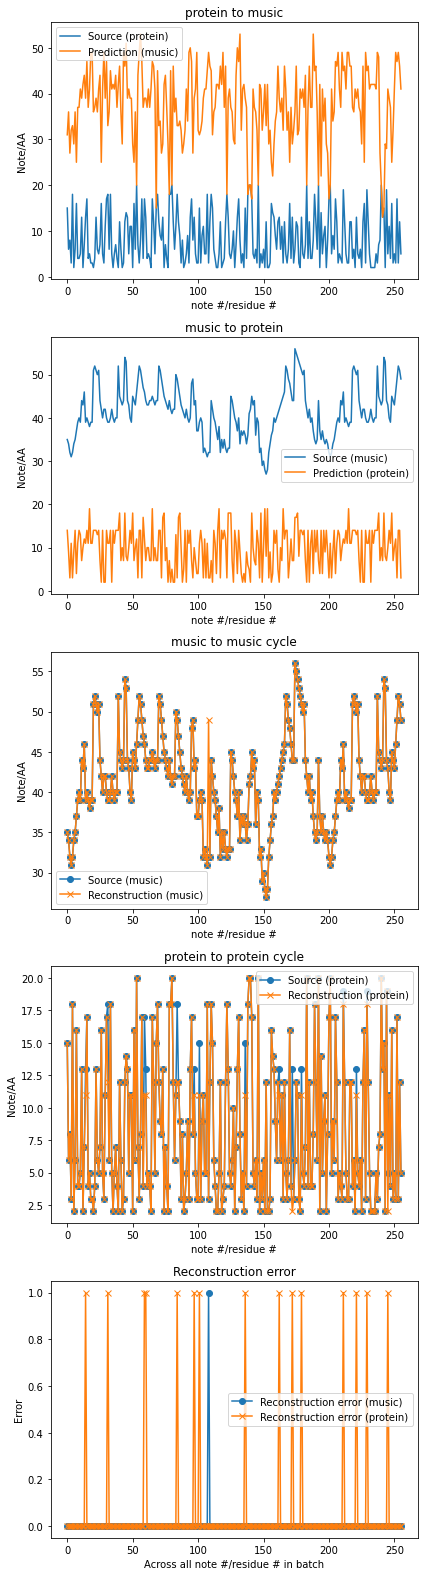

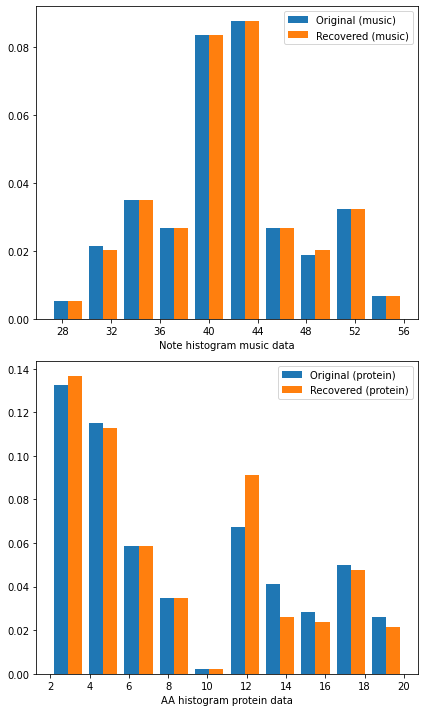

  1%|          | 11/1439 [00:53<1:56:59,  4.92s/it]

11 torch.Size([1, 256]) torch.Size([1, 256])
write original MIDI source music
WRITE MIDI FILE:  ./output/model_628fix-repeat/MIDI_sample_11_100.mid
[18 20 13 17 20 25 24 30 29 27 29 30 29 30 32 30 32 34 32 34 36 34 36 37
 36 37 39 37 39 41 39 41 43 41 43 44 43 44 46 44 46 48 46 48 49 22 20 22
 41 49 19 17 19 49 48 51 44 46 49 43 44 48 41 42 46 39 41 44 37 39 42 36
 37 25 24 27 20 32 31 27 29 31 32 34 36 34 32 41 44 43 41 43 44 39 36 32
 27 24 20 51 48 44 39 36 32 29 25 20 17 13 15 17 18 25 30 34 27 42 41 40
 41 43 45 46 45 43 45 46 48 49 48 46 48 49 51 53 51 49 51 53 54 45 54 53
 44 43 45 46 48 49 40 49 48 39 37 33 34 30 21 45 46 34 37 41 46 49 45 46
 41 37 38 47 46 42 39 32 41 30 39 29 37 30 39 36 45 44 41 37 30 39 29 37
 27 36 29 37 34 44 42 39 34 30 30 30 30 42 42 39 36 32 32 32 32 42 41 37
 44 42 39 46 44 29 25 47 46 49 42 44 47 41 42 46 39 41 44 37 39 42 36 37
 41 34 36 32 34 36 37 39 29 27 25 34 37 36 34 36]
write translated music from protein
WRITE MIDI FILE:  ./output/model_628

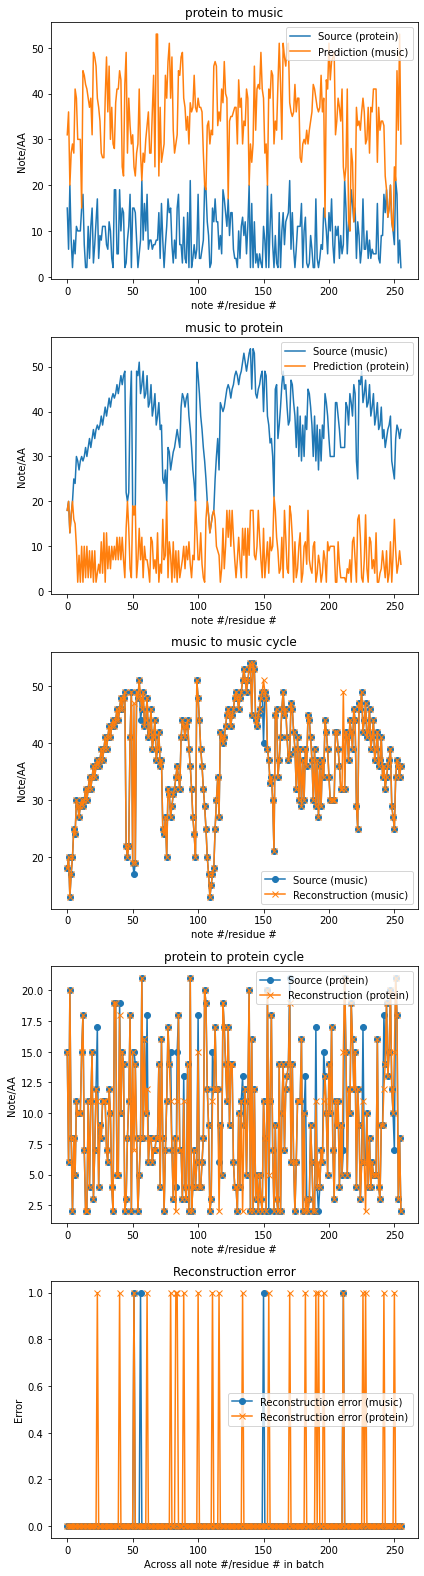

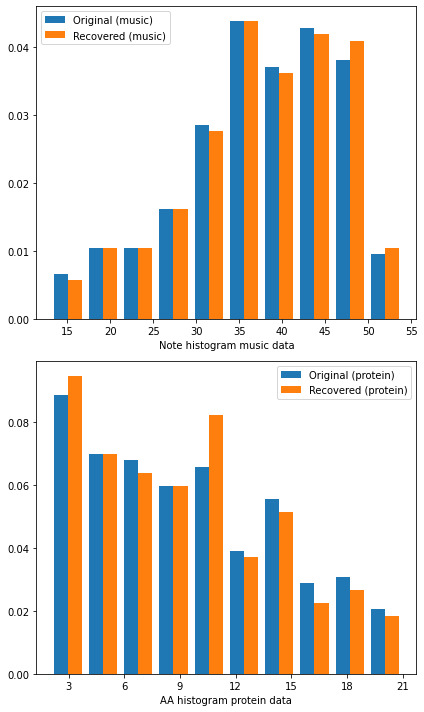

  1%|          | 11/1439 [00:58<2:06:51,  5.33s/it]


Overall accuracy over all samples = 0.95166015625
Overall accuracy over all samples A, B = 0.9951171875, 0.908203125


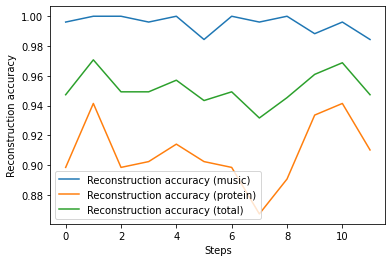

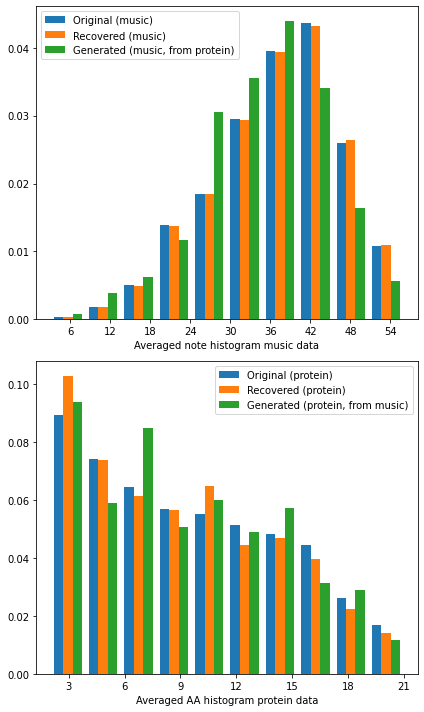

In [99]:
_,_,_,avg_acc,_,_ = validation_sampling (val_dataloader, num_samples=12, numbins=10,
                                        data1=data1, 
                                         data2=data2, 
                                         elements=elements,
                                    Note=Note, AA=AA,
                                         Note_AA=Note_AA,
                                        plot_generated=False)